In [1]:
import numpy as np
np.random.seed(2023)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
make_images = False

do_training = False

do_training_allzones = False

do_training_edward = False

model_name = 'model_vae'

#n_rows, n_cols, n_channels = 9, 191, 1
n_rows, n_cols, n_channels = 9, 95, 1

original_dim = n_rows * n_cols

interm_dim = 200

latent_dim = 2

learning_rate = 0.01

batch_size = 256

epochs = 40

### Import data

In [3]:
class RaggedTensorValue(object):
  # Based on
  #   https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/ragged/ragged_tensor_value.py
  def __init__(self, values, row_splits):
    if not (isinstance(row_splits, (np.ndarray, np.generic)) and
            row_splits.dtype == np.int64 and row_splits.ndim == 1):
      raise TypeError("row_splits must be a 1D int64 numpy array")
    if not isinstance(values, (np.ndarray, np.generic, RaggedTensorValue)):
      raise TypeError("values must be a numpy array or a RaggedTensorValue")
    self._values = values
    self._row_splits = row_splits

  row_splits = property(
      lambda self: self._row_splits,
      doc="""The split indices for the ragged tensor value.""")
  values = property(
      lambda self: self._values,
      doc="""The concatenated values for all rows in this tensor.""")
  dtype = property(
      lambda self: self._values.dtype,
      doc="""The numpy dtype of values in this tensor.""")

  @property
  def shape(self):
    """A tuple indicating the shape of this RaggedTensorValue."""
    return (self._row_splits.shape[0] - 1,) + (None,) + self._values.shape[1:]

  def to_list(self):
    """Returns this ragged tensor value as a nested Python list."""
    if isinstance(self._values, RaggedTensorValue):
      values_as_list = self._values.to_list()
    else:
      values_as_list = self._values.tolist()
    return [
        values_as_list[self._row_splits[i]:self._row_splits[i + 1]]
        for i in range(self._row_splits.shape[0] - 1)
    ]

  def to_array(self):
    """Returns this ragged tensor value as a nested Numpy array."""
    arr = np.empty((self._row_splits.shape[0] - 1,), dtype=np.object)
    for i in range(self._row_splits.shape[0] - 1):
      arr[i] = self._values[self._row_splits[i]:self._row_splits[i + 1]]
    return arr

In [4]:
if make_images:
  infile = '../test7/histos_tbf.2.npz'
  with np.load(infile) as loaded:
    out_part = loaded['out_part']
    out_hits = RaggedTensorValue(loaded['out_hits_values'], loaded['out_hits_row_splits'])
    out_hits = out_hits.to_array()
    print(out_part.shape, out_hits.shape)

  infile_omtf = '../test7/histos_tbf_omtf.2.npz'
  with np.load(infile_omtf) as loaded:
    out_part_omtf = loaded['out_part']
    out_hits_omtf = RaggedTensorValue(loaded['out_hits_values'], loaded['out_hits_row_splits'])
    out_hits_omtf = out_hits_omtf.to_array()
    print(out_part_omtf.shape, out_hits_omtf.shape)

    out_part = np.vstack((out_part, out_part_omtf))
    out_hits_tmp = np.empty((out_hits.shape[0] + out_hits_omtf.shape[0],), dtype=np.object)
    out_hits_tmp[:out_hits.shape[0]] = out_hits
    out_hits_tmp[out_hits.shape[0]:] = out_hits_omtf
    out_hits = out_hits_tmp
    print(out_part.shape, out_hits.shape)

### Find mean deflection angles

In [5]:
# Find 'quadstrip' unit
#PATTERN_X_SIZE = 48-1
#PATTERN_X_CENTRAL = 24-1
#PATTERN_X_DIV = 32

# Find 'dblstrip' unit
PATTERN_X_SIZE = 96-1
PATTERN_X_CENTRAL = 48-1
PATTERN_X_DIV = 16

# Find 'fullstrip' unit
#PATTERN_X_SIZE = 192-1
#PATTERN_X_CENTRAL = 96-1
#PATTERN_X_DIV = 8

PATTERN_X_SECTOR = 5400/PATTERN_X_DIV

nlayers = 16

nzones = 7

valid_layers = np.empty(nzones, dtype=np.object)
valid_layers[0] = [0,2,3,4,7,8,10,11]
valid_layers[1] = [0,2,3,4,7,8,9,10,11]
valid_layers[2] = [0,2,3,4,7,8,9,10]
valid_layers[3] = [0,2,3,4,7,8,9,10]
valid_layers[4] = [0,1,2,3,4,5,7,8,9]
valid_layers[5] = [1,2,3,4,5,6,7,8]
valid_layers[6] = [1,2,3,5,6,7,12,13,14]

layer_names = ['ME1/1', 'ME1/2', 'ME2', 'ME3', 'ME4',
               'RE1', 'RE2', 'RE3', 'RE4',
               'GE1/1', 'GE2/1', 'ME0',
               'MB1', 'MB2', 'MB3', 'MB4']
assert(len(layer_names) == nlayers)

ordered_layer_names = ['MB1',
                       'ME0', 'GE1/1', 'ME1/1',
                       'MB2',
                       'ME1/2', 'RE1',
                       'MB3',
                       'GE2/1', 'RE2', 'ME2',
                       'MB4',
                       'ME3', 'RE3',
                       'ME4', 'RE4',]
assert(len(ordered_layer_names) == nlayers)

from six.moves import range, zip, map, filter

def _find_bin_fast(x, bins):
  x = np.clip(x, bins[1], bins[2]-1e-7)
  binx = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
  return binx.astype(np.int32)

def find_eta_bin_16(eta, bins=(16,0.8,2.4)):
  return _find_bin_fast(np.abs(eta), bins)

def find_pt_bin_100(pt, bins=(100,-0.5,0.5)):
  return _find_bin_fast(pt, bins)

_get_emtf_layer = lambda x: x[0]

_get_emtf_phi = lambda x: x[1]

def _find_dphi(phi1, phi2):
  dphi = np.float32(0)
  dphi += (phi1 - phi2)
  #dphi /= (np.sinh(1.8587) / np.sinh(np.abs(part_eta)))
  dphi /= PATTERN_X_DIV
  dphi = np.round(dphi)
  return dphi.astype(np.int32)

In [6]:
patterns_match_me2_0 = np.zeros((100, 16, nlayers, PATTERN_X_SIZE), dtype=np.int32)
patterns_match_me3_0 = np.zeros((100, 16, nlayers, PATTERN_X_SIZE), dtype=np.int32)

def analysis(verbose=1):

  # Loop over part and hits
  ievt = 0

  for part, hits in zip(out_part, out_hits):
    if verbose and (ievt % 100000 == 0):  print("Processing event: {0}".format(ievt))

    (part_invpt, part_eta, part_phi, part_d0, zone, endsec) = part
    zone = zone.astype(np.int32)

    ipt100 = find_pt_bin_100(part_invpt)
    ieta16 = find_eta_bin_16(part_eta)

    amap = {}  # emtf_layer -> hit

    for ihit, hit in enumerate(hits):
      amap.setdefault(_get_emtf_layer(hit), []).append(ihit)

    for k, v in amap.iteritems():
      ihit = np.random.choice(v)  # pick a random hit for each emtf_layer
      amap[k] = hits[ihit]

    # Make pair of hits
    for k, v in amap.iteritems():
      emtf_layer = k
      hit1 = v
      hit_phi1 = _get_emtf_phi(hit1)

      # w.r.t ME2
      emtf_layer_me2 = 2
      hit2 = amap.get(emtf_layer_me2, None)
      if hit2 is not None:
        hit_phi2 = _get_emtf_phi(hit2)
        dphi = _find_dphi(hit_phi1, hit_phi2)
        dphi = np.clip(dphi, -PATTERN_X_CENTRAL, PATTERN_X_CENTRAL)
        ind = (ipt100, ieta16, emtf_layer, dphi+PATTERN_X_CENTRAL)
        patterns_match_me2_0[ind] += 1

        # Debug
        if ievt < 10:
          print ievt, part_invpt, part_eta, emtf_layer, hit_phi1, hit_phi2, dphi

      # w.r.t ME3
      emtf_layer_me3 = 3
      hit2 = amap.get(emtf_layer_me3, None)
      if hit2 is not None:
        hit_phi2 = _get_emtf_phi(hit2)
        dphi = _find_dphi(hit_phi1, hit_phi2)
        dphi = np.clip(dphi, -PATTERN_X_CENTRAL, PATTERN_X_CENTRAL)
        ind = (ipt100, ieta16, emtf_layer, dphi+PATTERN_X_CENTRAL)
        patterns_match_me3_0[ind] += 1

    ievt += 1
    # end loop over part and hits

  if verbose: print "DONE"
  return

In [7]:
%%time

if make_images:
  # Run analysis
  analysis()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.15 µs


In [8]:
# Styling
plt.style.use('tdrstyle.mplstyle')

# https://matplotlib.org/users/dflt_style_changes.html#colors-in-default-property-cycle
# https://github.com/vega/vega/wiki/Scales#scale-range-literals
category10_palette  = ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf')
category20_palette  = ('#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5')
category10a_palette = ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5')

from matplotlib.colors import LinearSegmentedColormap
cdict = {
  'blue' : ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
blue_hot = LinearSegmentedColormap('blue_hot', cdict)

<div>
  <div title="#1f77b4" style="background: #1f77b4; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#ff7f0e" style="background: #ff7f0e; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#2ca02c" style="background: #2ca02c; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#d62728" style="background: #d62728; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#9467bd" style="background: #9467bd; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#8c564b" style="background: #8c564b; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#e377c2" style="background: #e377c2; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#7f7f7f" style="background: #7f7f7f; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#bcbd22" style="background: #bcbd22; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#17becf" style="background: #17becf; display: inline-block; width: 28px; height: 28px;"></div>
  <br/>
  <div title="#aec7e8" style="background: #aec7e8; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#ffbb78" style="background: #ffbb78; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#98df8a" style="background: #98df8a; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#ff9896" style="background: #ff9896; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#c5b0d5" style="background: #c5b0d5; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#c49c94" style="background: #c49c94; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#f7b6d2" style="background: #f7b6d2; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#c7c7c7" style="background: #c7c7c7; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#dbdb8d" style="background: #dbdb8d; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#9edae5" style="background: #9edae5; display: inline-block; width: 28px; height: 28px;"></div>
</div>

In [9]:
if make_images:
  # Make probability
  patterns_match_me2_1 = patterns_match_me2_0.astype(np.float32)
  patterns_match_me3_1 = patterns_match_me3_0.astype(np.float32)

  # Fix issues due to gap between ME2/1 & ME2/2 at eta=1.6
  # eta 1.5-1.6 -> 7
  # eta 1.6-1.7 -> 8
  patterns_match_me2_1[:,6,:,:] += patterns_match_me2_0[:,7,:,:]
  patterns_match_me2_1[:,7,:,:] += patterns_match_me2_0[:,6,:,:]
  patterns_match_me2_1[:,8,:,:] += patterns_match_me2_0[:,9,:,:]
  patterns_match_me2_1[:,9,:,:] += patterns_match_me2_0[:,8,:,:]

  # Fix issues due to gap between ME3/1 & ME3/2 at eta=1.7
  # eta 1.6-1.7 -> 8
  # eta 1.7-1.8 -> 9
  patterns_match_me3_1[:,7,:,:] += patterns_match_me3_0[:,8,:,:]
  patterns_match_me3_1[:,8,:,:] += patterns_match_me3_0[:,7,:,:]
  patterns_match_me3_1[:,9,:,:] += patterns_match_me3_0[:,10,:,:]
  patterns_match_me3_1[:,10,:,:] += patterns_match_me3_0[:,9,:,:]
  
  # Fix issues due to beginning of ME1/1 at eta=1.5
  # eta 1.5-1.6 -> 7, emtf_layer = 0
  patterns_match_me2_1[:,7,0,:] += patterns_match_me2_0[:,8,0,:]
  patterns_match_me2_1[:,8,0,:] += patterns_match_me2_0[:,7,0,:]
  patterns_match_me3_1[:,7,0,:] += patterns_match_me3_0[:,8,0,:]
  patterns_match_me3_1[:,8,0,:] += patterns_match_me3_0[:,7,0,:]
  
  patterns_match_me2_1[:,6,0,:] += patterns_match_me2_0[:,8,0,:]
  
  # Fix issues due to end of ME1/2 at eta=1.6
  # eta 1.6-1.7 -> 8, emtf_layer = 1
  patterns_match_me2_1[:,8,1,:] += patterns_match_me2_0[:,7,1,:]
  patterns_match_me2_1[:,7,1,:] += patterns_match_me2_0[:,8,1,:]
  patterns_match_me3_1[:,8,1,:] += patterns_match_me3_0[:,7,1,:]
  patterns_match_me3_1[:,7,1,:] += patterns_match_me3_0[:,8,1,:]
  
  patterns_match_me2_1[:,9,1,:] += patterns_match_me2_0[:,7,1,:]
  
  # Fix issues due to beginning of GE1/1 at eta=1.5
  # eta 1.5-1.6 -> 7, emtf_layer = 9
  patterns_match_me2_1[:,7,9,:] += patterns_match_me2_0[:,8,9,:]
  patterns_match_me2_1[:,8,9,:] += patterns_match_me2_0[:,7,9,:]
  patterns_match_me3_1[:,7,9,:] += patterns_match_me3_0[:,8,9,:]
  patterns_match_me3_1[:,8,9,:] += patterns_match_me3_0[:,7,9,:]
  
  patterns_match_me2_1[:,6,9,:] += patterns_match_me2_0[:,8,9,:]
  
  # Fix issues due to end of RE1/2 at eta=1.6
  # eta 1.6-1.7 -> 8, emtf_layer = 5
  patterns_match_me2_1[:,8,5,:] += patterns_match_me2_0[:,7,5,:]
  patterns_match_me2_1[:,7,5,:] += patterns_match_me2_0[:,8,5,:]
  patterns_match_me3_1[:,8,5,:] += patterns_match_me3_0[:,7,5,:]
  patterns_match_me3_1[:,7,5,:] += patterns_match_me3_0[:,8,5,:]
  
  patterns_match_me2_1[:,9,5,:] += patterns_match_me2_0[:,7,5,:]
  
  # For MB1, ignore eta dependence
  # eta 0.8-1.3 -> 0-4, emtf_layer = 12
  patterns_match_me2_1[:,0,12,:] += patterns_match_me2_0[:,1,12,:]
  patterns_match_me2_1[:,0,12,:] += patterns_match_me2_0[:,2,12,:]
  patterns_match_me2_1[:,0,12,:] += patterns_match_me2_0[:,3,12,:]
  patterns_match_me2_1[:,0,12,:] += patterns_match_me2_0[:,4,12,:]
  
  patterns_match_me2_1[:,1,12,:] = patterns_match_me2_1[:,0,12,:]
  patterns_match_me2_1[:,2,12,:] = patterns_match_me2_1[:,0,12,:]
  patterns_match_me2_1[:,3,12,:] = patterns_match_me2_1[:,0,12,:]
  patterns_match_me2_1[:,4,12,:] = patterns_match_me2_1[:,0,12,:]
  
  # For MB2, ignore eta dependence
  # eta 0.8-1.1 -> 0-2, emtf_layer = 13
  patterns_match_me2_1[:,0,13,:] += patterns_match_me2_0[:,1,13,:]
  patterns_match_me2_1[:,0,13,:] += patterns_match_me2_0[:,2,13,:]
  
  patterns_match_me2_1[:,1,13,:] = patterns_match_me2_1[:,0,13,:]
  patterns_match_me2_1[:,2,13,:] = patterns_match_me2_1[:,0,13,:]
  
  # For ME1 & RE1 in Overlap, ignore eta dependence
  # eta 0.8-1.0 -> 0-1, emtf_layer = 1 & 5
  for l in (1,5):
    patterns_match_me2_1[:,0,l,:] += patterns_match_me2_0[:,1,l,:]
    
    patterns_match_me2_1[:,1,l,:] = patterns_match_me2_1[:,0,l,:]
    
  # For ME2 & RE2 in Overlap, ignore eta dependence
  # eta 0.8-1.1 -> 0-2, emtf_layer = 2 & 6
  for l in (2,6):
    patterns_match_me2_1[:,0,l,:] += patterns_match_me2_0[:,1,l,:]
    patterns_match_me2_1[:,0,l,:] += patterns_match_me2_0[:,2,l,:]
    
    patterns_match_me2_1[:,1,l,:] = patterns_match_me2_1[:,0,l,:]
    patterns_match_me2_1[:,2,l,:] = patterns_match_me2_1[:,0,l,:]
  
  # For ME3 & RE3 in Overlap, ignore eta dependence
  # eta 0.8-1.2 -> 0-3, emtf_layer = 3 & 7
  for l in (3,7):
    patterns_match_me2_1[:,0,l,:] += patterns_match_me2_0[:,1,l,:]
    patterns_match_me2_1[:,0,l,:] += patterns_match_me2_0[:,2,l,:]
    patterns_match_me2_1[:,0,l,:] += patterns_match_me2_0[:,3,l,:]
    
    patterns_match_me2_1[:,1,l,:] = patterns_match_me2_1[:,0,l,:]
    patterns_match_me2_1[:,2,l,:] = patterns_match_me2_1[:,0,l,:]
    patterns_match_me2_1[:,3,l,:] = patterns_match_me2_1[:,0,l,:]
    
  # For ME4 & RE4 in Overlap, ignore eta dependence
  # eta 0.8-1.3 -> 0-4, emtf_layer = 4 & 8
  for l in (4,8):
    patterns_match_me2_1[:,0,l,:] += patterns_match_me2_0[:,1,l,:]
    patterns_match_me2_1[:,0,l,:] += patterns_match_me2_0[:,2,l,:]
    patterns_match_me2_1[:,0,l,:] += patterns_match_me2_0[:,3,l,:]
    patterns_match_me2_1[:,0,l,:] += patterns_match_me2_0[:,4,l,:]
    
    patterns_match_me2_1[:,1,l,:] = patterns_match_me2_1[:,0,l,:]
    patterns_match_me2_1[:,2,l,:] = patterns_match_me2_1[:,0,l,:]
    patterns_match_me2_1[:,3,l,:] = patterns_match_me2_1[:,0,l,:]
    patterns_match_me2_1[:,4,l,:] = patterns_match_me2_1[:,0,l,:]

In [10]:
if make_images:
  # Normalize
  patterns_match_me2_1_sum = patterns_match_me2_1.sum(axis=-1, keepdims=True)
  patterns_match_me3_1_sum = patterns_match_me3_1.sum(axis=-1, keepdims=True)
  patterns_match_me2_1[(patterns_match_me2_1_sum < 100)[...,0]] = 0
  patterns_match_me3_1[(patterns_match_me3_1_sum < 100)[...,0]] = 0
  patterns_match_me2_1_sum[patterns_match_me2_1_sum == 0] = 1
  patterns_match_me3_1_sum[patterns_match_me3_1_sum == 0] = 1
  patterns_match_me2_1 /= patterns_match_me2_1_sum
  patterns_match_me3_1 /= patterns_match_me3_1_sum

  # Add up the probabilities
  #patterns_match_me2_2 = 0.5 * (patterns_match_me2_1 + patterns_match_me3_1)
  patterns_match_me2_2 = 0.25 * (3*patterns_match_me2_1 + 1*patterns_match_me3_1)
  
  # But do not add the probabilities in Overlap or for MB1-4
  patterns_match_me2_2[:,0:4,:,:] = patterns_match_me2_1[:,0:4,:,:]
  patterns_match_me2_2[:,:,12:16,:] = patterns_match_me2_1[:,:,12:16,:]
  
  # Reverse dphi
  patterns_match_me2_2 = patterns_match_me2_2[::-1]

  # Sanity check
  print patterns_match_me2_1[50,:,3].sum(axis=-1)
  print patterns_match_me3_1[50,:,2].sum(axis=-1)
  print patterns_match_me2_2[50,:,3].sum(axis=-1)

In [11]:
if make_images:
  # w.r.t ME2
  fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(8,8), sharex=True, sharey=True)

  for i in xrange(nlayers):
    for j in xrange(16):  # ieta16
      yy = np.zeros(100, dtype=np.float32) + PATTERN_X_CENTRAL
      for k in xrange(100):  # ipt100
        if patterns_match_me2_1[k,j,i].sum() > 0:
          yy[k] = np.searchsorted(patterns_match_me2_1[k,j,i].cumsum(), 0.5)  # median
      ax = axs[i/4,i%4]
      ax.plot(np.arange(len(yy))+0.5, yy-PATTERN_X_CENTRAL, color=category10a_palette[j])
      ax.set_ylim(-50,50)

  plt.show()

In [12]:
if make_images:
  # w.r.t ME3
  fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(8,8), sharex=True, sharey=True)

  for i in xrange(nlayers):
    for j in xrange(16):  # ieta16
      yy = np.zeros(100, dtype=np.float32) + PATTERN_X_CENTRAL
      for k in xrange(100):  # ipt100
        if patterns_match_me3_1[k,j,i].sum() > 0:
          yy[k] = np.searchsorted(patterns_match_me3_1[k,j,i].cumsum(), 0.5)  # median
      ax = axs[i/4,i%4]
      ax.plot(np.arange(len(yy))+0.5, yy-PATTERN_X_CENTRAL, color=category10a_palette[j])
      ax.set_ylim(-50,50)

  plt.show()

### Find patterns

In [13]:
def analysis2(verbose=1):

  images_0 = np.zeros((out_part.shape[0], nlayers, PATTERN_X_SIZE), dtype=np.bool)
  images_1 = np.zeros((out_part.shape[0], nlayers, PATTERN_X_SIZE), dtype=np.bool)  # mirror
  labels_0 = np.zeros((out_part.shape[0], 3), dtype=np.float32)
  labels_1 = np.zeros((out_part.shape[0], 3), dtype=np.float32)  # mirror

  # Loop over part and hits
  ievt = 0

  for part, hits in zip(out_part, out_hits):
    if verbose and (ievt % 100000 == 0):  print("Processing event: {0}".format(ievt))

    (part_invpt, part_eta, part_phi, part_d0, zone, endsec) = part
    zone = zone.astype(np.int32)

    ipt100 = find_pt_bin_100(part_invpt)
    ieta16 = find_eta_bin_16(part_eta)

    # Part I - find keystrip
    xx = np.zeros(PATTERN_X_SECTOR, dtype=np.float32)

    for ihit, hit in enumerate(hits):
      emtf_layer = _get_emtf_layer(hit)
      hit_phi1 = _get_emtf_phi(hit)
      hit_phi2 = 0
      dphi = _find_dphi(hit_phi1, hit_phi2)
      
      # Ignore MB3, MB4
      if emtf_layer == 14 or emtf_layer == 15:
        continue

      likelihood = patterns_match_me2_2[ipt100, ieta16, emtf_layer]

      ind1 = dphi-PATTERN_X_CENTRAL
      ind2 = dphi+PATTERN_X_CENTRAL+1
      if ind1 < 0:
        xx[:ind2] += likelihood[-ind1:]
      elif ind2 > xx.shape[0]:
        xx[ind1:] += likelihood[:-ind2 + xx.shape[0]]
      else:
        xx[ind1:ind2] += likelihood

      # Debug
      if ievt < 10:
        print ievt, part_invpt, part_eta, emtf_layer, hit_phi1, hit_phi2, dphi, np.argmax(likelihood)-PATTERN_X_CENTRAL

    if xx.sum() == 0:
      keystrip = -1
    else:
      keystrip = np.argmax(xx)  # max likelihood

    # Part II - make image
    img0 = np.zeros((nlayers, PATTERN_X_SIZE), dtype=np.bool)
    img1 = np.zeros((nlayers, PATTERN_X_SIZE), dtype=np.bool)  # mirror

    if keystrip >= 0:
      for ihit, hit in enumerate(hits):
        emtf_layer = _get_emtf_layer(hit)
        hit_phi1 = _get_emtf_phi(hit)
        hit_phi2 = 0
        dphi = _find_dphi(hit_phi1, hit_phi2)

        row = emtf_layer
        col = (dphi - keystrip)
        if -PATTERN_X_CENTRAL <= col <= PATTERN_X_CENTRAL:
          img0[row, +col+PATTERN_X_CENTRAL] = 1
          img1[row, -col+PATTERN_X_CENTRAL] = 1

        # Debug
        if ievt < 10:
          print '..', part_invpt, part_eta, emtf_layer, hit_phi1, hit_phi2, dphi, keystrip, col

    images_0[ievt] = img0
    images_1[ievt] = img1
    labels_0[ievt] = (part_invpt, part_d0, zone)
    labels_1[ievt] = (-part_invpt, part_d0, zone)
    ievt += 1
    # end loop over part and hits

  if verbose: print "DONE"
  return np.concatenate((images_0, images_1)), np.concatenate((labels_0, labels_1))

In [14]:
%%time

if make_images:
  # Run analysis
  images, labels = analysis2()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.15 µs


In [15]:
if make_images:
  outfile = 'keras_logs/myimages_out.npz'
  np.savez_compressed(outfile, images=images, labels=labels)

In [16]:
if not make_images:
  infile = 'keras_logs/myimages_out.2.dblstrip.npz'
  with np.load(infile) as loaded:
    images = loaded['images']
    labels = loaded['labels']

### Training

In [17]:
import os
import sys
os.environ['KERAS_BACKEND'] = 'tensorflow'

import tensorflow as tf

import keras
from keras import backend as K
K.set_image_data_format('channels_last')

Using TensorFlow backend.


In [18]:
def load_dataset():
  zone_sel = labels[:, 2].astype(np.int32)
  zone_sel = (zone_sel == zone)
  zimages = images[zone_sel]
  zlabels = labels[zone_sel]
  zlayers = sorted(valid_layers[zone], key=lambda x: ordered_layer_names.index(layer_names[x]))

  # Hack to make n_rows == 9
  while len(zlayers) < 9:
    zlayers += [15]  # MB4 layer is always empty

  zimages = zimages[:, zlayers]
  zimages = zimages[:,:,:,np.newaxis]
  zimages = zimages.astype(np.float32)
  print(zimages.shape, zimages.dtype, zlabels.shape, zlabels.dtype)
  assert(original_dim == zimages.shape[1] * zimages.shape[2])
  zimages = zimages.reshape([-1, original_dim])
  
  nentries = zimages.shape[0]

  x_train, x_test, y_train, y_test = zimages[:nentries/2], zimages[nentries/2:], zlabels[:nentries/2], zlabels[nentries/2:]
  print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
  return x_train, x_test, y_train, y_test

In [19]:
def draw_images():

  # (i) Average of all images
  img = np.zeros((n_rows * n_cols,), dtype=np.float32)
  img += (x_train.sum(axis=0)) 
  img += (x_test.sum(axis=0))
  print (x_train.shape[0] + x_test.shape[0]), img.min(), img.max()
  img /= img.max()
  img = img.reshape((n_rows, n_cols))

  from matplotlib.colors import LogNorm
  from matplotlib.ticker import LogLocator
  #my_cmap = plt.cm.viridis
  my_cmap = blue_hot
  my_cmap.set_under('k')
  vmin = 1e-4
  eps = 1e-7

  zlayers = sorted(valid_layers[zone], key=lambda x: ordered_layer_names.index(layer_names[x]))

  fig, ax = plt.subplots(1, 1, figsize=(4,3.2), tight_layout=True)
  cs = ax.imshow(img + eps, origin='lower', interpolation='nearest', aspect='auto',
                 cmap=my_cmap, vmin=vmin, norm=LogNorm(vmin=vmin, vmax=1))
  cbar = fig.colorbar(cs)
  cbar.set_ticks(LogLocator())
  plt.yticks(np.arange(len(zlayers)), [layer_names[x] for x in zlayers], fontsize=10)
  plt.show()

  # (ii) Random pick of 16 images
  n = 4
  ind = np.random.randint(x_train.shape[0], size=n*n)
  img = np.zeros((n_rows * n, n_cols * n), dtype=np.float32)

  for i in xrange(n):
    for j in xrange(n):
      random_img = x_train[ind[(i*n)+j]].reshape((n_rows, n_cols))
      img[i*n_rows:(i+1)*n_rows, j*n_cols:(j+1)*n_cols] = random_img

  fig, ax = plt.subplots(1, 1, figsize=(6,6), tight_layout=True)
  cs = ax.imshow(img, origin='lower', interpolation='nearest', aspect='auto',
                 cmap=blue_hot, vmin=0, vmax=1.6)
  for i in xrange(1,n):
    ax.plot([-0.5+i*n_cols,-0.5+i*n_cols], [-0.5,-0.5+n*n_rows], color='w', linewidth=0.5, alpha=0.6)
    ax.plot([-0.5,-0.5+n*n_cols], [-0.5+i*n_rows,-0.5+i*n_rows], color='w', linewidth=0.5, alpha=0.6)
  ax.axis('off')
  plt.show()

  # (iii) Binned by pT
  n = 9
  #edges = np.linspace(-0.5, 0.5, num=n+1)
  if zone in (0,1,):
    edges = np.array([-0.5, -0.32, -0.22, -0.13, -0.04, 0.04, 0.13, 0.22, 0.32, 0.5], dtype=np.float32)
  elif zone in (2,3,4,):
    edges = np.array([-0.5, -0.30, -0.21, -0.125, -0.04, 0.04, 0.125, 0.21, 0.30, 0.5], dtype=np.float32)
  elif zone in (5,):
    edges = np.array([-0.33, -0.23, -0.13, -0.085, -0.04, 0.04, 0.085, 0.13, 0.23, 0.33], dtype=np.float32)
  elif zone in (6,):
    edges = np.array([-0.25, -0.15, -0.11, -0.07, -0.03, 0.03, 0.07, 0.11, 0.15, 0.25], dtype=np.float32)
  else:
    edges = None
    
  if zone in (0,1,2,3,4):
    emtf_layer_me1 = 0
    act = 0.08
  elif zone in (5,):
    emtf_layer_me1 = 1
    act = 0.07
  elif zone in (6,):
    emtf_layer_me1 = 12
    act = 0.06
    
  me1_row = zlayers.index(emtf_layer_me1)
  #me1_cdf = img[me1_row].cumsum() / img[me1_row].sum()
  #edges_p = np.linspace(0.05, 0.95, num=n+1)
  
  img = np.zeros((n_rows * 1, n_cols * n), dtype=np.float32)
  img_w_mask = np.zeros((n_rows * 1, n_cols * n), dtype=np.float32)

  for i in xrange(n):
    pt_low = edges[:-1][i]
    pt_high = edges[1:][i]

    pt_img = np.zeros((n_rows * n_cols,), dtype=np.float32)
    pt_sel = (pt_low <= y_train[:,0]) & (y_train[:,0] <= pt_high)
    pt_img += (x_train[pt_sel]).sum(axis=0)
    pt_sel = (pt_low <= y_test[:,0]) & (y_test[:,0] <= pt_high)
    pt_img += (x_test[pt_sel]).sum(axis=0)
    pt_img /= pt_img.max()
    pt_img = pt_img.reshape((n_rows, n_cols))
    img[0*n_rows:(0+1)*n_rows, i*n_cols:(i+1)*n_cols] = pt_img

    pt_img_mask = pt_img.copy()
    #norm = pt_img_mask.sum(axis=-1, keepdims=True)
    norm = np.sqrt(np.square(pt_img_mask).sum(axis=-1, keepdims=True))
    assert(np.isfinite(norm).all())
    norm[norm == 0] = 1
    pt_img_mask /= norm
    #print i, pt_img_mask[me1_row]
    pt_img_mask = np.where(pt_img_mask < act, 0, 1)
    img_w_mask[0*n_rows:(0+1)*n_rows, i*n_cols:(i+1)*n_cols] = pt_img * pt_img_mask
    
    ## Pattern making
    #for j in xrange(n_rows):
    #  _cdf = pt_img[j].cumsum() / pt_img[j].sum()
    #  _window0 = np.searchsorted(_cdf, [0.05,0.5,0.95])
    #  _valid = np.nonzero(pt_img_mask[j])[0]
    #  _window1 = _valid[0], _valid[-1]
    #  print (zone, i, zlayers[j]), _window0, _window1
    #  if not ((_valid[-1] - _valid[0]) == len(_valid) - 1):
    #    print("[WARNING] The range is not continuous. Please check!")
    #  if not (_window1[0] <= _window0[1] <= _window1[1]):
    #    print("[WARNING] Median not included in the window. Please check!")

  fig, ax = plt.subplots(1, 1, figsize=(9,2), tight_layout=True)
  cs = ax.imshow(img + eps, origin='lower', interpolation='nearest', aspect='auto',
                 cmap=my_cmap, vmin=vmin, norm=LogNorm(vmin=vmin, vmax=1))
  for i in xrange(1,n):
    ax.plot([-0.5+i*n_cols,-0.5+i*n_cols], [-0.5,-0.5+n_rows], color='w', linewidth=0.5, alpha=0.6)
  ax.axis('off')
  plt.show()

  fig, ax = plt.subplots(1, 1, figsize=(9,2), tight_layout=True)
  cs = ax.imshow(img_w_mask + eps, origin='lower', interpolation='nearest', aspect='auto',
                 cmap=my_cmap, vmin=vmin, norm=LogNorm(vmin=vmin, vmax=1))
  for i in xrange(1,n):
    ax.plot([-0.5+i*n_cols,-0.5+i*n_cols], [-0.5,-0.5+n_rows], color='w', linewidth=0.5, alpha=0.6)
  ax.axis('off')
  plt.show()

In [20]:
def draw_images2():
  
  # (iv) Binned by ME1 phi
  img = np.zeros((n_rows * n_cols,), dtype=np.float32)
  img += (x_train.sum(axis=0)) 
  img += (x_test.sum(axis=0))
  print (x_train.shape[0] + x_test.shape[0]), img.min(), img.max()
  img /= img.max()
  img = img.reshape((n_rows, n_cols))
  
  from matplotlib.colors import LogNorm
  from matplotlib.ticker import LogLocator
  #my_cmap = plt.cm.viridis
  my_cmap = blue_hot
  my_cmap.set_under('k')
  vmin = 1e-4
  eps = 1e-7

  zlayers = sorted(valid_layers[zone], key=lambda x: ordered_layer_names.index(layer_names[x]))

  n = 9  # num of pt bins

  if zone in (0,1,2,3,4):
    emtf_layer_me1 = 0
  elif zone in (5,):
    emtf_layer_me1 = 1
  elif zone in (6,):
    emtf_layer_me1 = 12
    
  me1_row = zlayers.index(emtf_layer_me1)
  me1_cdf = img[me1_row].cumsum() / img[me1_row].sum()
  edges_p = np.linspace(0.05, 0.95, num=n+1)
  
  if zone in (0,1,2,3,4):
    edges_p[0] = 0.01
    edges_p[-1] = 0.99
  elif zone in (5,):
    edges_p[0] = 0.02
    edges_p[-1] = 0.98
  elif zone in (6,):
    edges_p[0] = 0.03
    edges_p[-1] = 0.97
  
  edges = np.searchsorted(me1_cdf, edges_p)  # edges in ME1 phi
  print zone, me1_row, edges

  h2 = np.zeros((n, 200), dtype=np.float32)  # x: patterns, y: pT
  pt_edges = np.linspace(-0.5, 0.5, num=201) # edges of initial pt bins

  for i in xrange(n):
    low = edges[:-1][i]
    high = edges[1:][i]
    x = x_train.reshape(-1, n_rows, n_cols)[:, me1_row, low:high+1]
    sel = np.any(x, axis=1)
    assert(x.shape[0] == sel.shape[0])

    y = y_train[sel][:, 0]
    hist, e = np.histogram(y, bins=200, range=(-0.5,0.5))
    assert(np.allclose(e, pt_edges))
    h2[i] += hist

    x = x_test.reshape(-1, n_rows, n_cols)[:, me1_row, low:high+1]
    sel = np.any(x, axis=1)
    assert(x.shape[0] == sel.shape[0])

    y = y_test[sel][:, 0]
    hist, e = np.histogram(y, bins=200, range=(-0.5,0.5))
    assert(np.allclose(e, pt_edges))
    h2[i] += hist

  h2_argmax = np.argmax(h2, axis=0)
  
  if zone in (0,1,):
    pass
  elif zone in (2,3,4,):
    # Ignore 2.5 GeV and below
    h2_argmax[:20] = n+1
    h2_argmax[-20:] = n+1
  elif zone in (5,):
    # Ignore 3 GeV and below
    h2_argmax[:34] = n+1
    h2_argmax[-34:] = n+1
  elif zone in (6,):
    # Ignore 4 GeV and below
    h2_argmax[:50] = n+1
    h2_argmax[-50:] = n+1

  img = np.zeros((n_rows * 1, n_cols * n), dtype=np.float32)
  new_pt_edges = np.linspace(0.05, 0.95, num=n+1) # edges of final pt bins

  for i in xrange(n):
    pt_low = (pt_edges[:-1][h2_argmax == i]).min()
    pt_high = (pt_edges[1:][h2_argmax == i]).max()
    new_pt_edges[i] = pt_low
    new_pt_edges[i+1] = pt_high
    def is_continuous(a):
      a = np.nonzero(a)[0]
      return len(a) == np.max(a) - np.min(a) + 1
    assert(is_continuous(h2_argmax == i))

    pt_img = np.zeros((n_rows * n_cols,), dtype=np.float32)
    pt_sel = (pt_low <= y_train[:,0]) & (y_train[:,0] <= pt_high)
    pt_img += (x_train[pt_sel]).sum(axis=0)
    pt_sel = (pt_low <= y_test[:,0]) & (y_test[:,0] <= pt_high)
    pt_img += (x_test[pt_sel]).sum(axis=0)
    pt_img /= pt_img.max()
    pt_img = pt_img.reshape((n_rows, n_cols))
    img[0*n_rows:(0+1)*n_rows, i*n_cols:(i+1)*n_cols] = pt_img

  print zone, me1_row, new_pt_edges

  fig, ax = plt.subplots(1, 1, figsize=(4,3.2), tight_layout=True)
  cs = ax.imshow(h2, origin='lower', interpolation='nearest', aspect='auto',
                 cmap=plt.cm.viridis)
  cbar = fig.colorbar(cs)
  plt.show()

  fig, ax = plt.subplots(1, 1, figsize=(9,2), tight_layout=True)
  cs = ax.imshow(img + eps, origin='lower', interpolation='nearest', aspect='auto',
                 cmap=my_cmap, vmin=vmin, norm=LogNorm(vmin=vmin, vmax=1))
  for i in xrange(1,n):
    ax.plot([-0.5+i*n_cols,-0.5+i*n_cols], [-0.5,-0.5+n_rows], color='w', linewidth=0.5, alpha=0.6)
  ax.axis('off')
  plt.show()

((983334, 9, 95, 1), dtype('float32'), (983334, 3), dtype('float32'))
((491667, 855), (491667, 855), (491667, 3), (491667, 3))
983334 0.0 824860.0


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-matplotlib/2.2.3-ikaegh/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


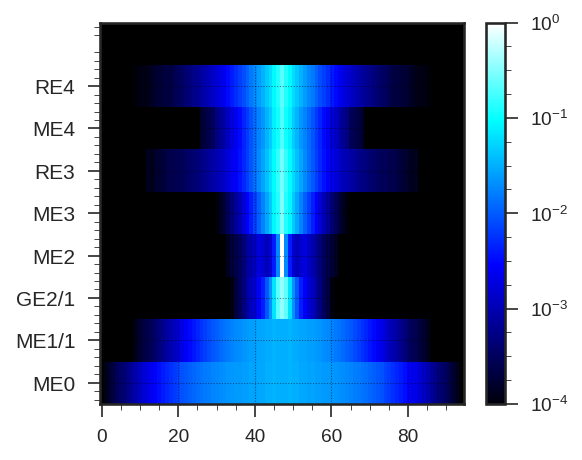

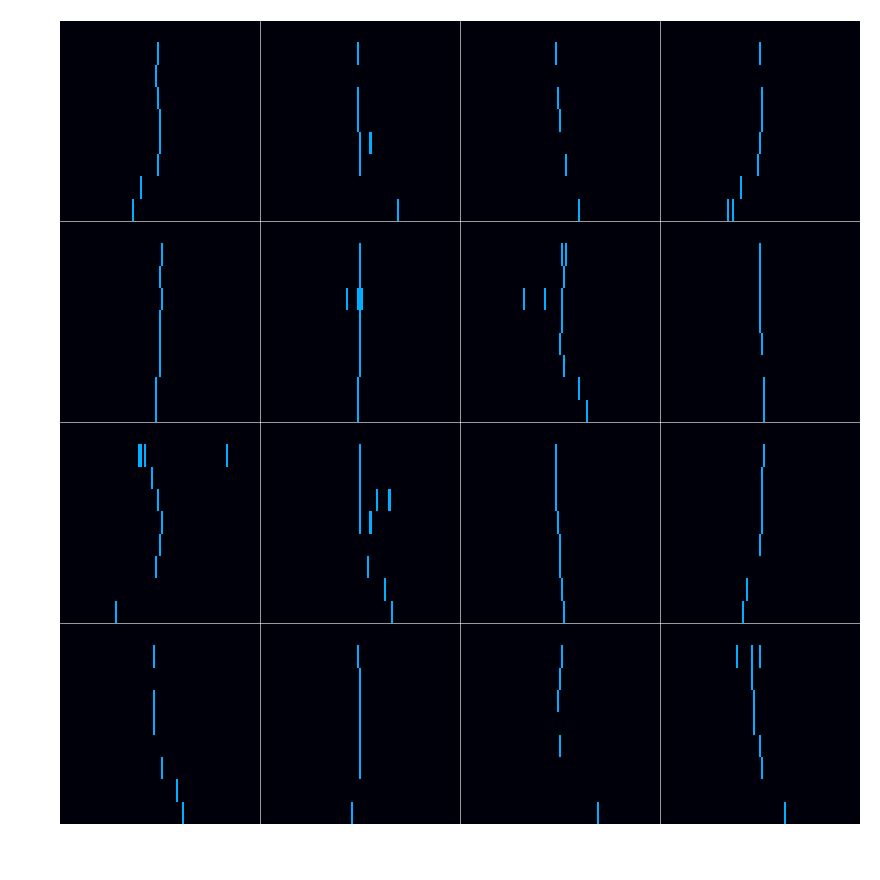

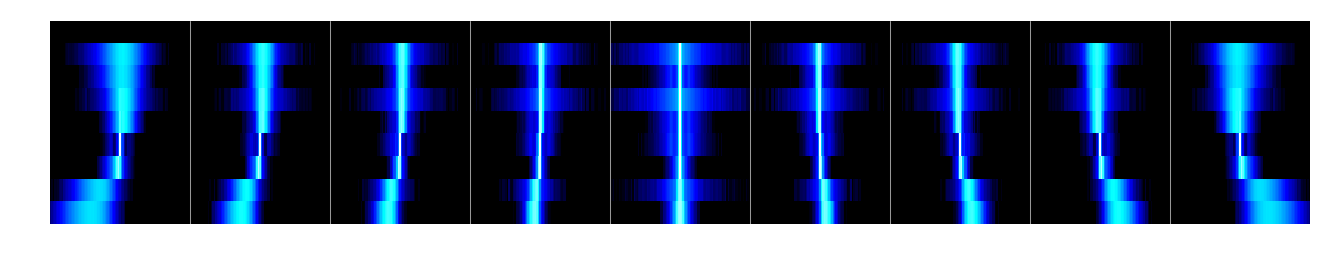

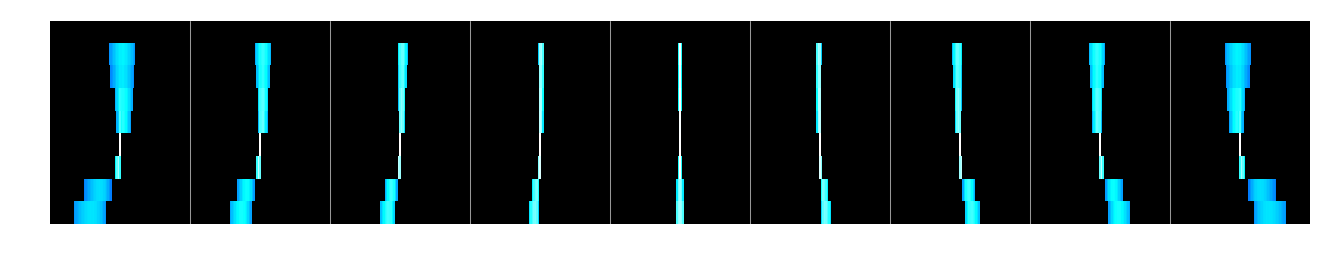

983334 0.0 824860.0
0 1 [21 35 39 43 46 48 51 55 59 73]
0 1 [-0.5   -0.32  -0.23  -0.12  -0.025  0.025  0.12   0.23   0.32   0.5  ]


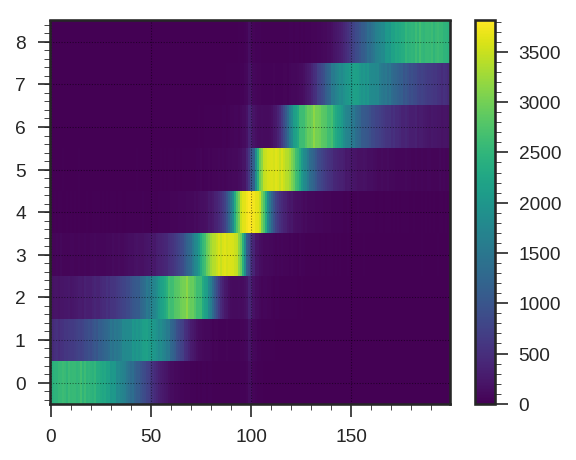

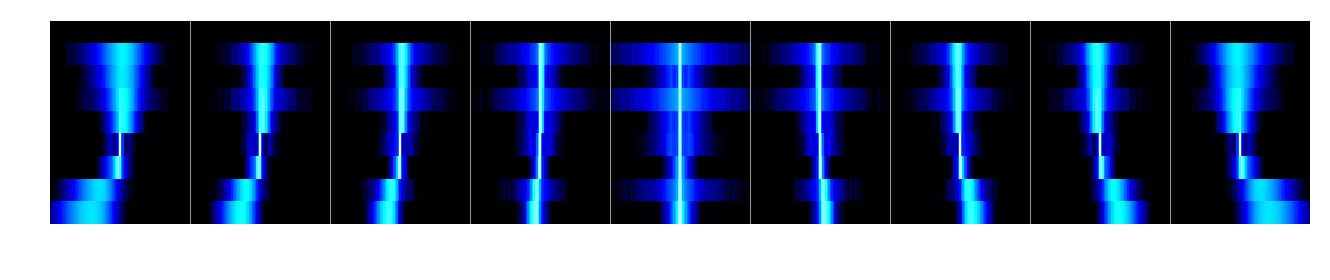

((609176, 9, 95, 1), dtype('float32'), (609176, 3), dtype('float32'))
((304588, 855), (304588, 855), (304588, 3), (304588, 3))
609176 0.0 467626.0


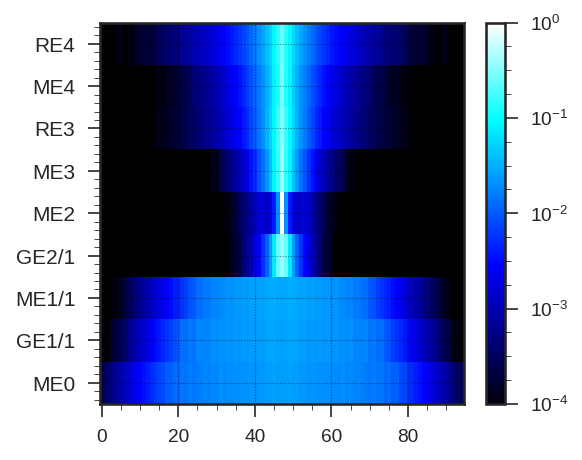

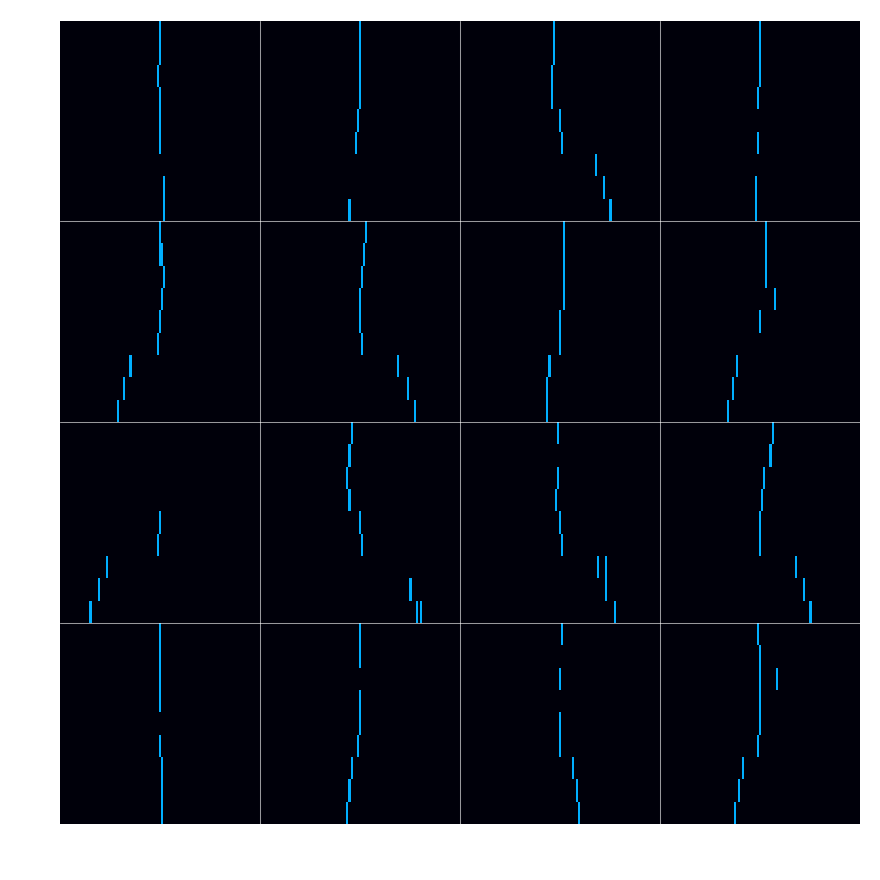

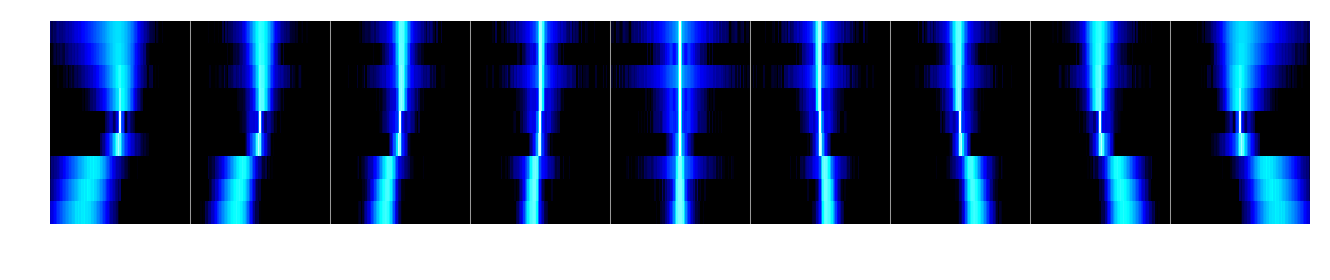

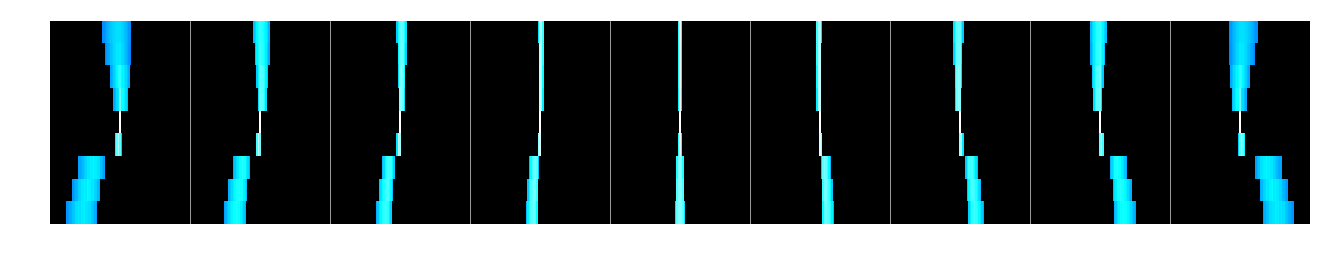

609176 0.0 467626.0
1 2 [17 32 37 41 45 49 53 57 62 77]
1 2 [-0.5   -0.32  -0.22  -0.135 -0.045  0.045  0.135  0.22   0.32   0.5  ]


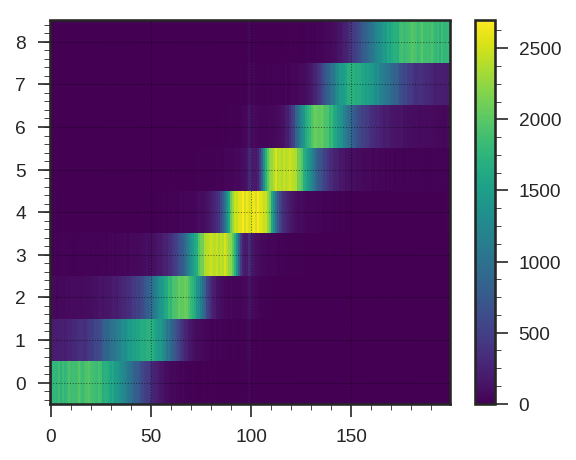

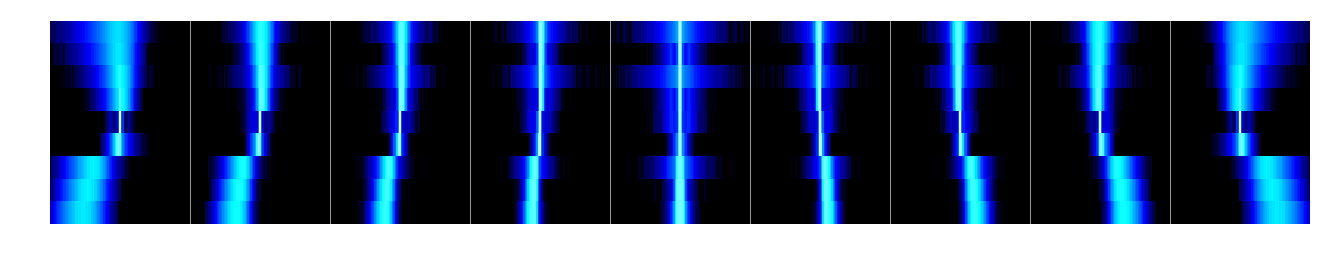

((576854, 9, 95, 1), dtype('float32'), (576854, 3), dtype('float32'))
((288427, 855), (288427, 855), (288427, 3), (288427, 3))
576854 0.0 478952.0


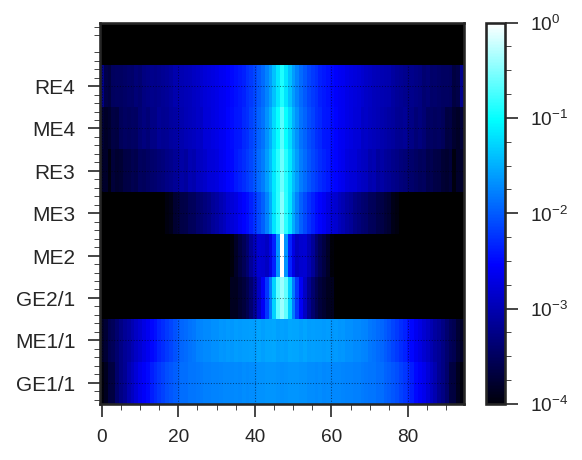

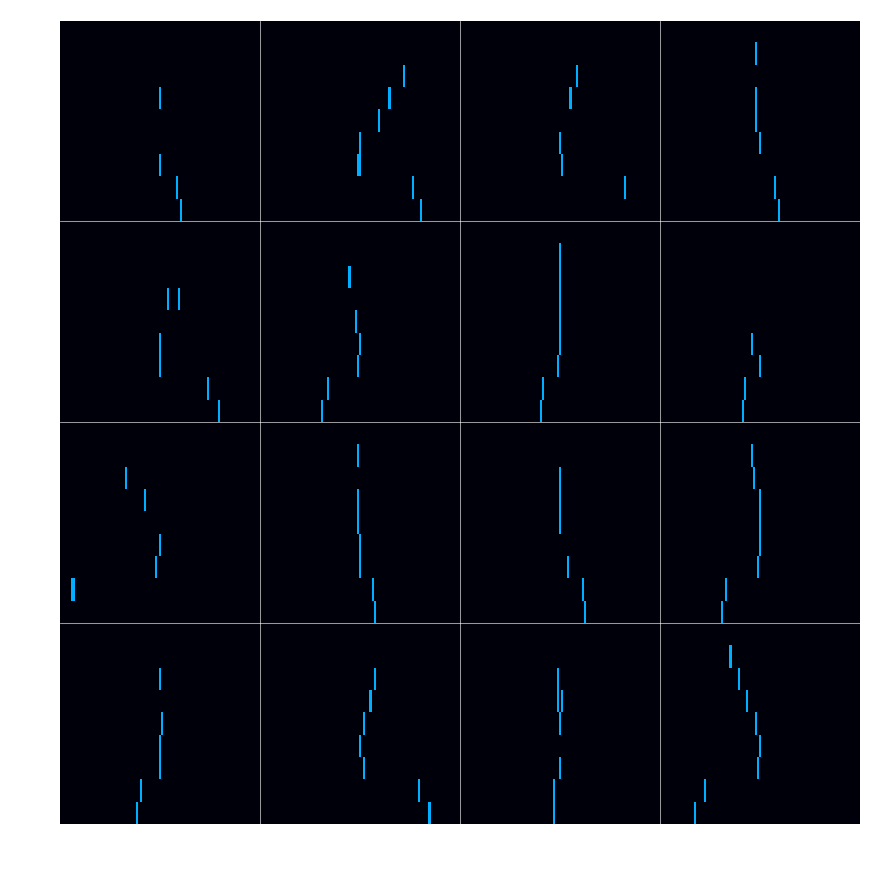

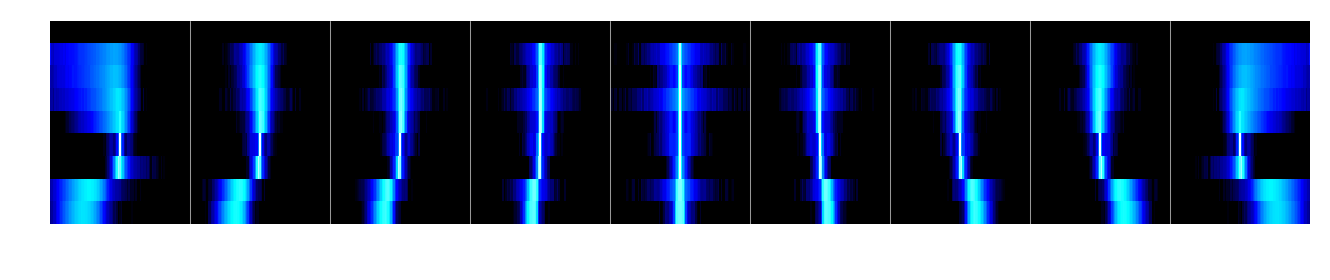

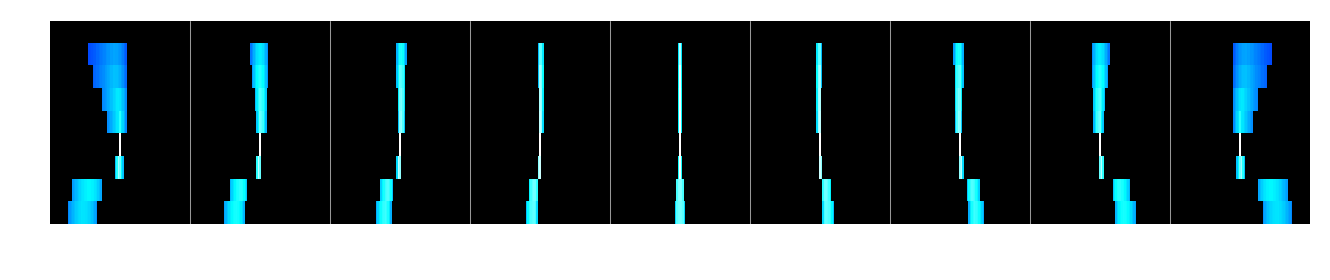

576854 0.0 478952.0
2 1 [13 29 35 40 45 49 54 59 65 81]
2 1 [-0.4   -0.315 -0.22  -0.13  -0.04   0.04   0.13   0.22   0.315  0.4  ]


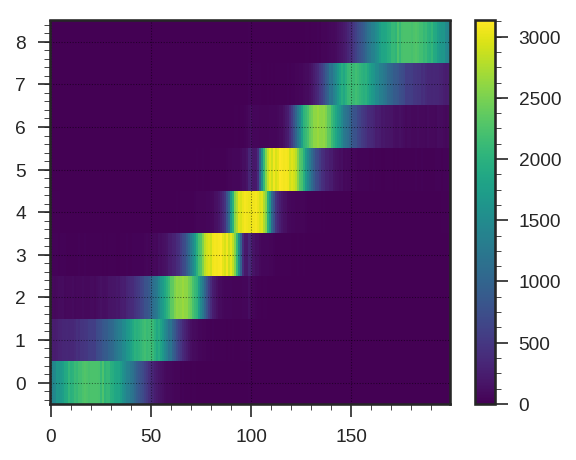

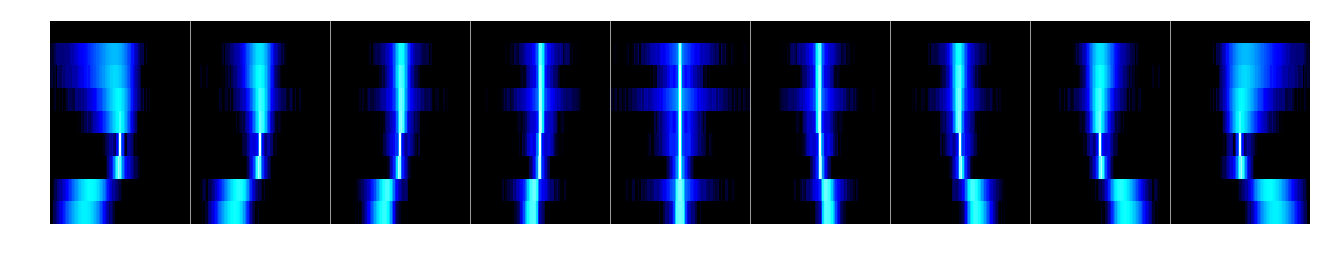

((420470, 9, 95, 1), dtype('float32'), (420470, 3), dtype('float32'))
((210235, 855), (210235, 855), (210235, 3), (210235, 3))
420470 0.0 320376.0


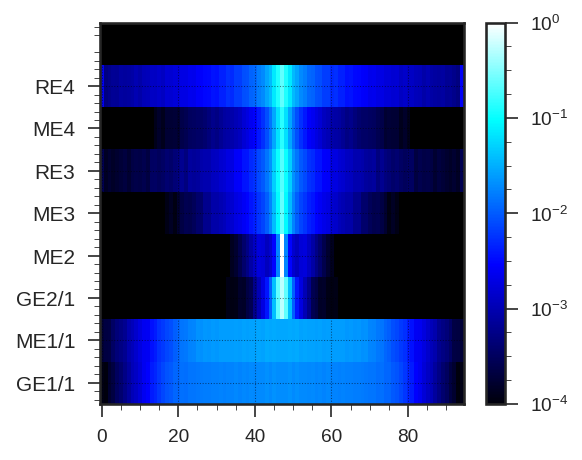

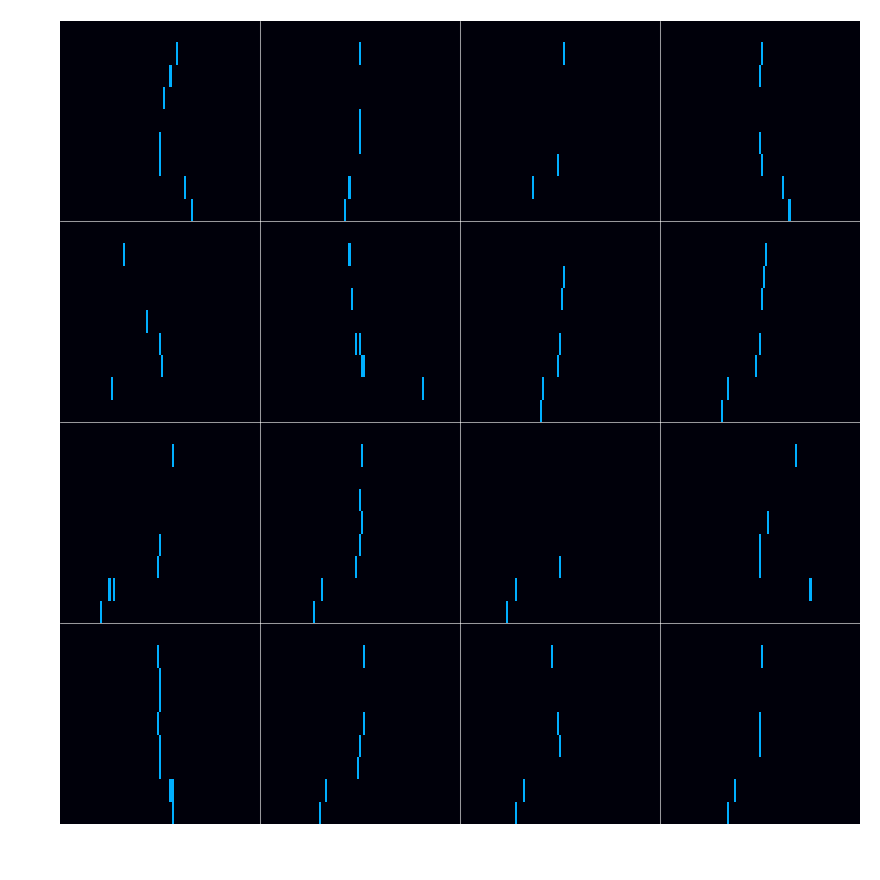

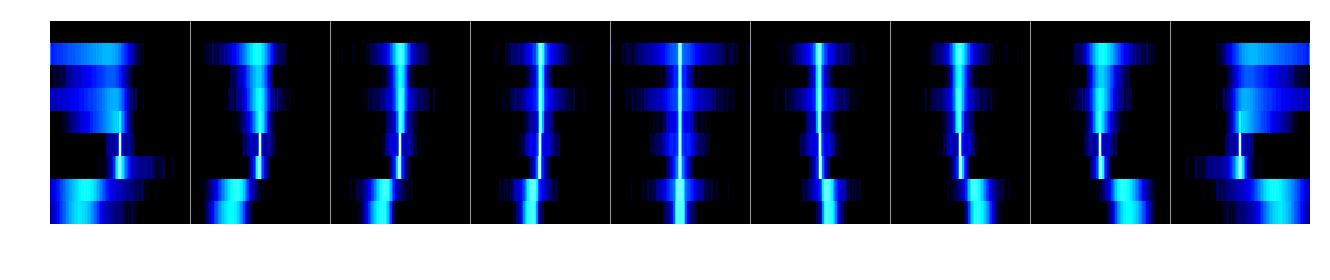

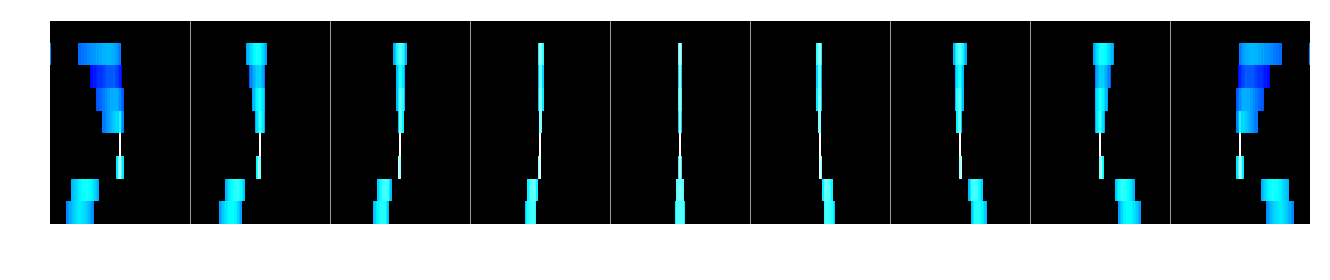

420470 0.0 320376.0
3 1 [13 28 34 39 45 49 55 60 66 81]
3 1 [-0.4   -0.285 -0.2   -0.13  -0.035  0.035  0.13   0.2    0.285  0.4  ]


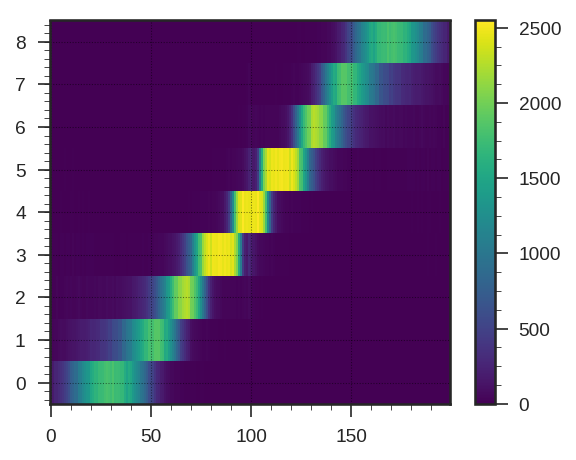

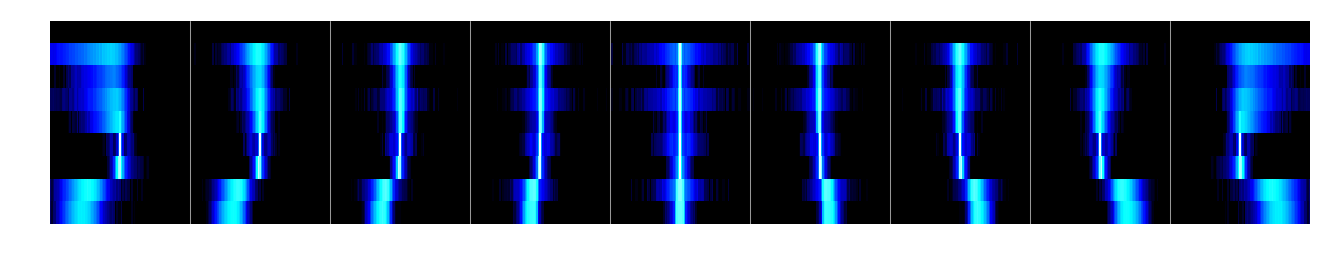

((522526, 9, 95, 1), dtype('float32'), (522526, 3), dtype('float32'))
((261263, 855), (261263, 855), (261263, 3), (261263, 3))
522526 0.0 252998.0


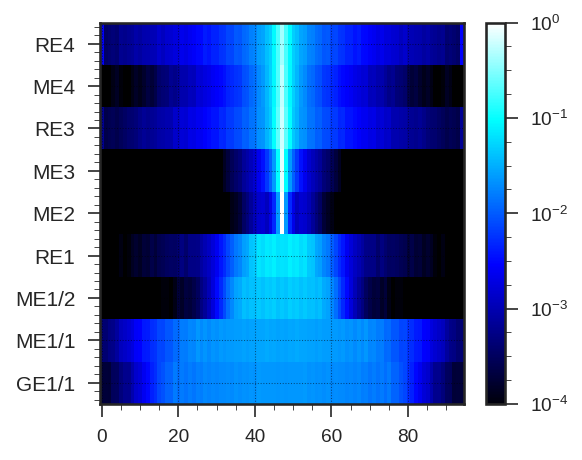

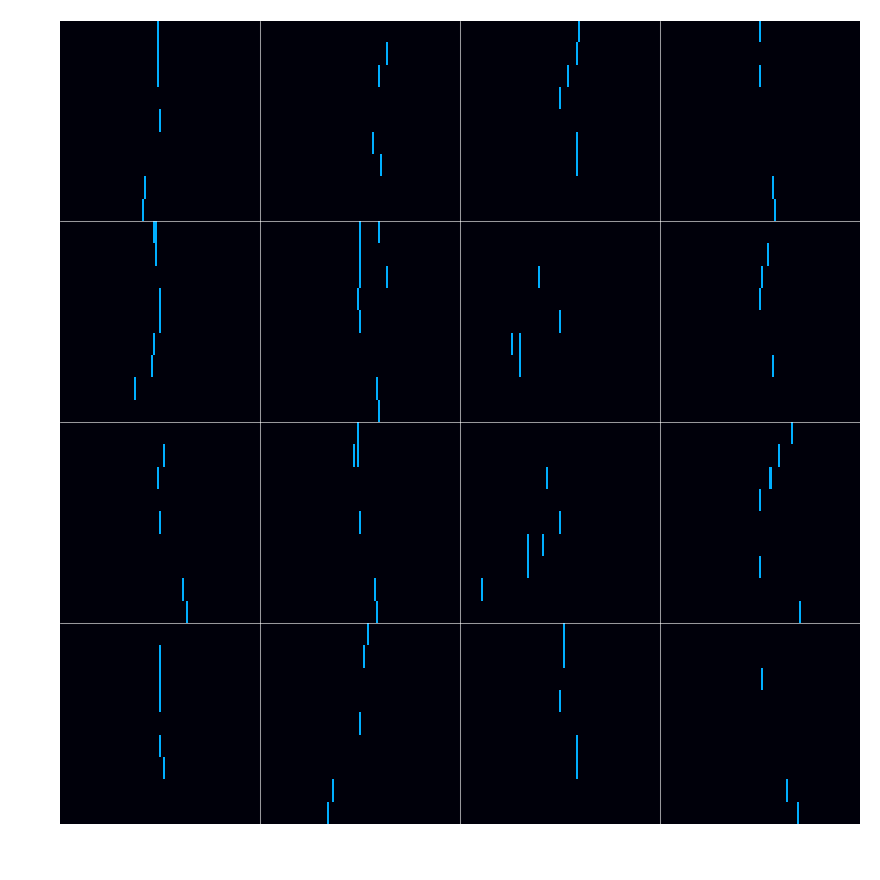

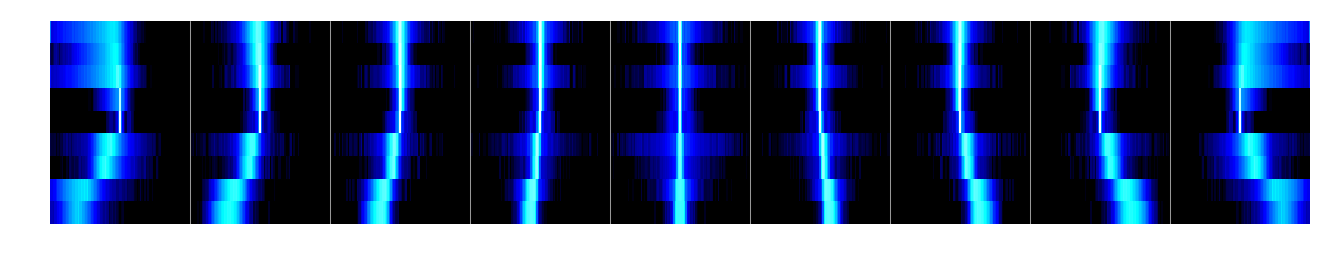

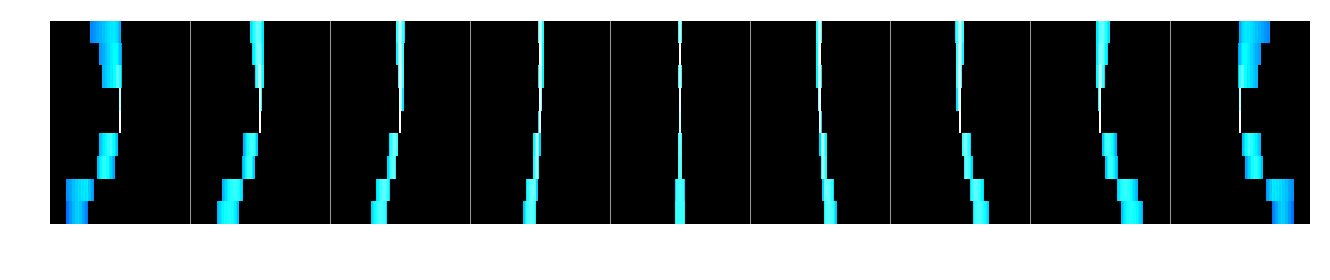

522526 0.0 252998.0
4 1 [11 27 34 39 44 50 55 60 67 83]
4 1 [-0.4   -0.28  -0.19  -0.12  -0.045  0.045  0.12   0.19   0.28   0.4  ]


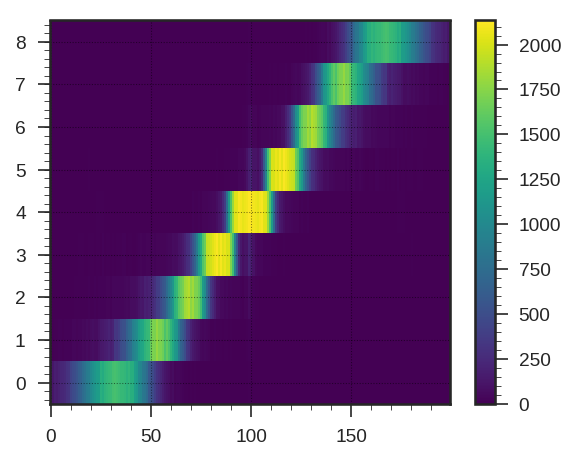

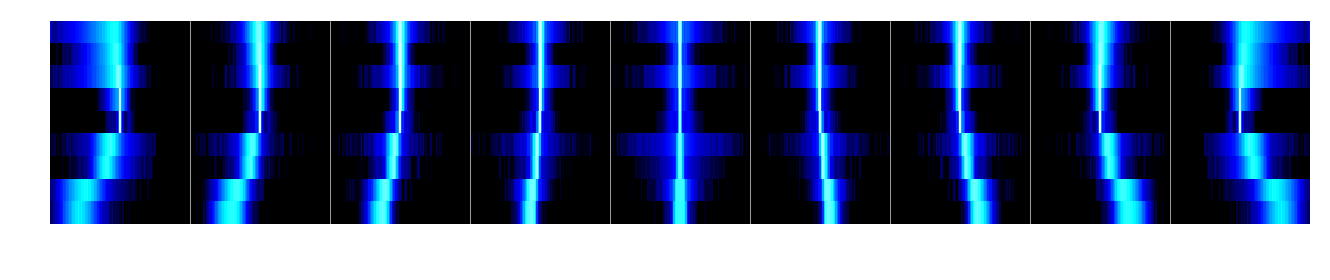

((2269202, 9, 95, 1), dtype('float32'), (2269202, 3), dtype('float32'))
((1134601, 855), (1134601, 855), (1134601, 3), (1134601, 3))
2269202 0.0 1804920.0


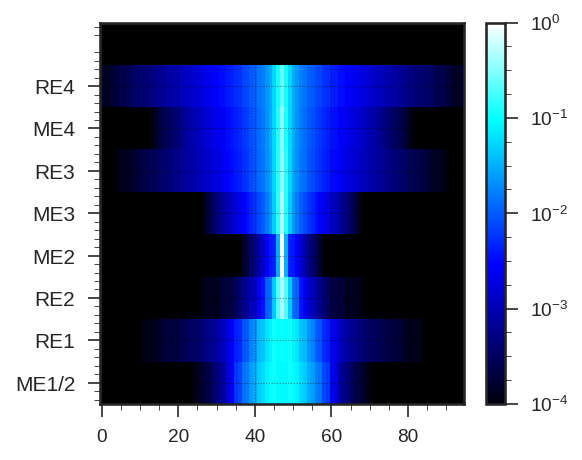

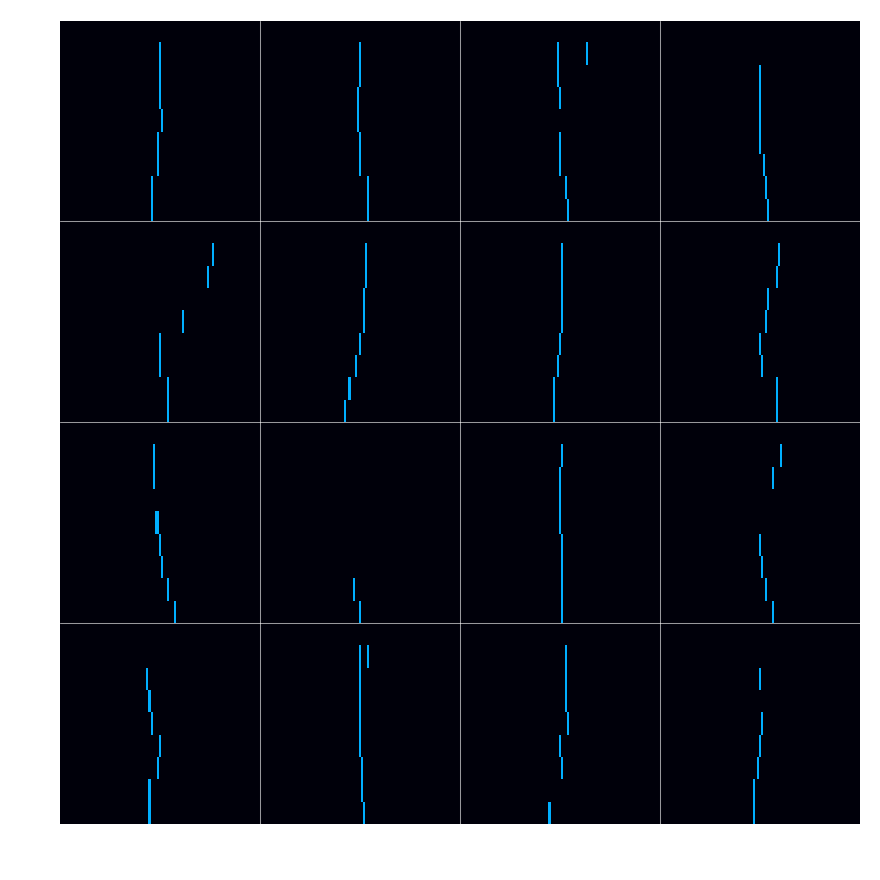

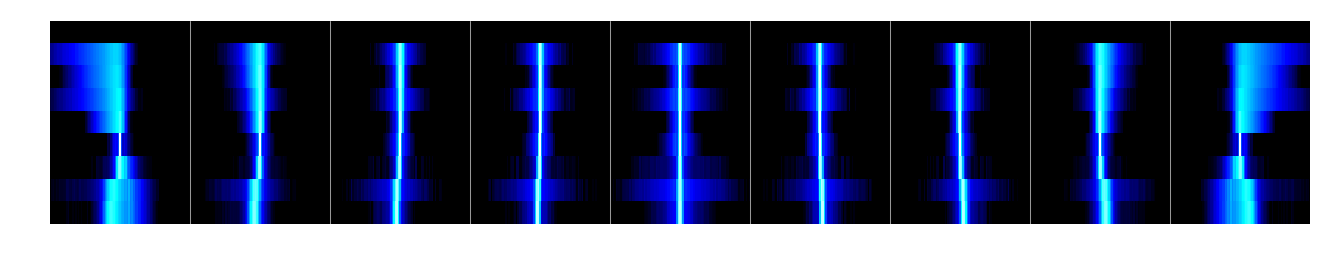

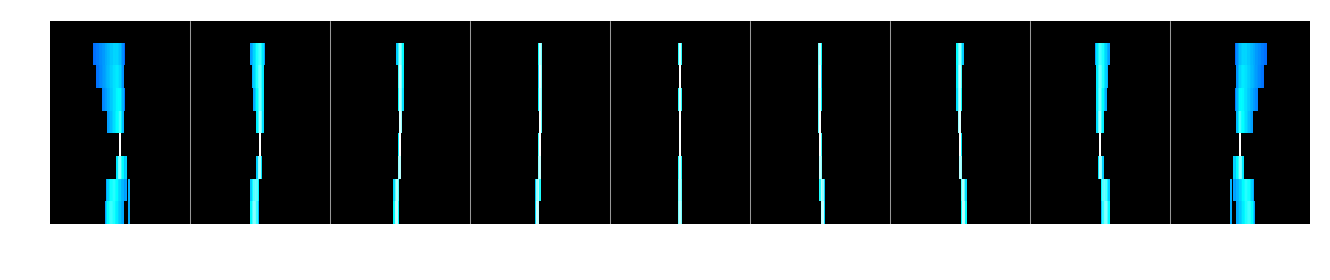

2269202 0.0 1804920.0
5 0 [37 42 44 45 46 48 49 50 52 57]
5 0 [-0.33  -0.235 -0.13  -0.085 -0.04   0.04   0.085  0.13   0.235  0.33 ]


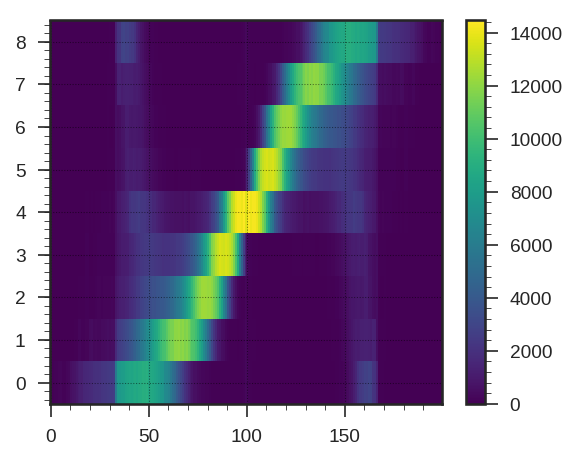

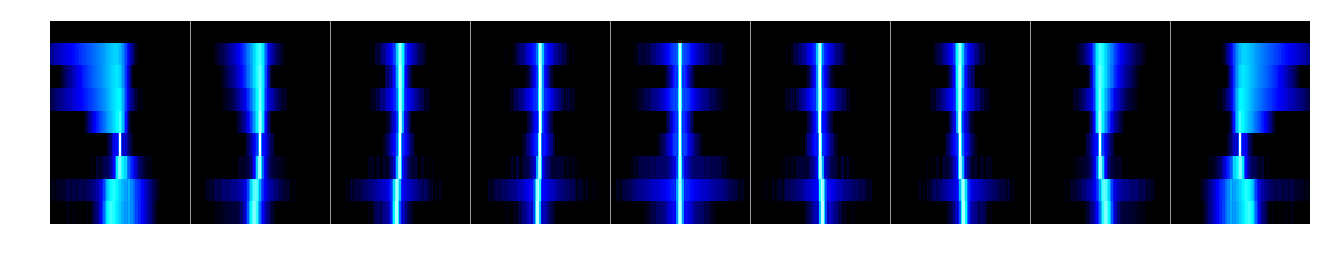

((2512558, 9, 95, 1), dtype('float32'), (2512558, 3), dtype('float32'))
((1256279, 855), (1256279, 855), (1256279, 3), (1256279, 3))
2512558 0.0 1376250.0


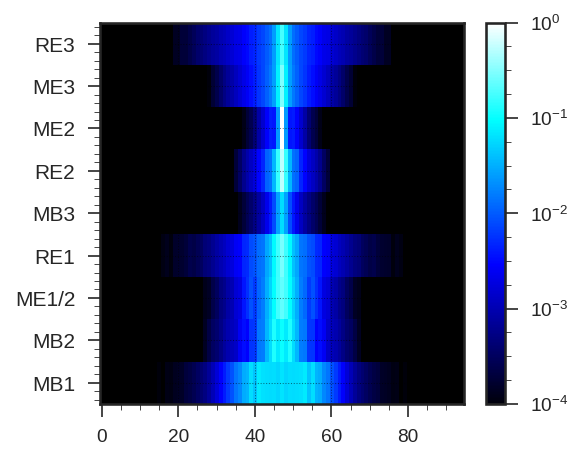

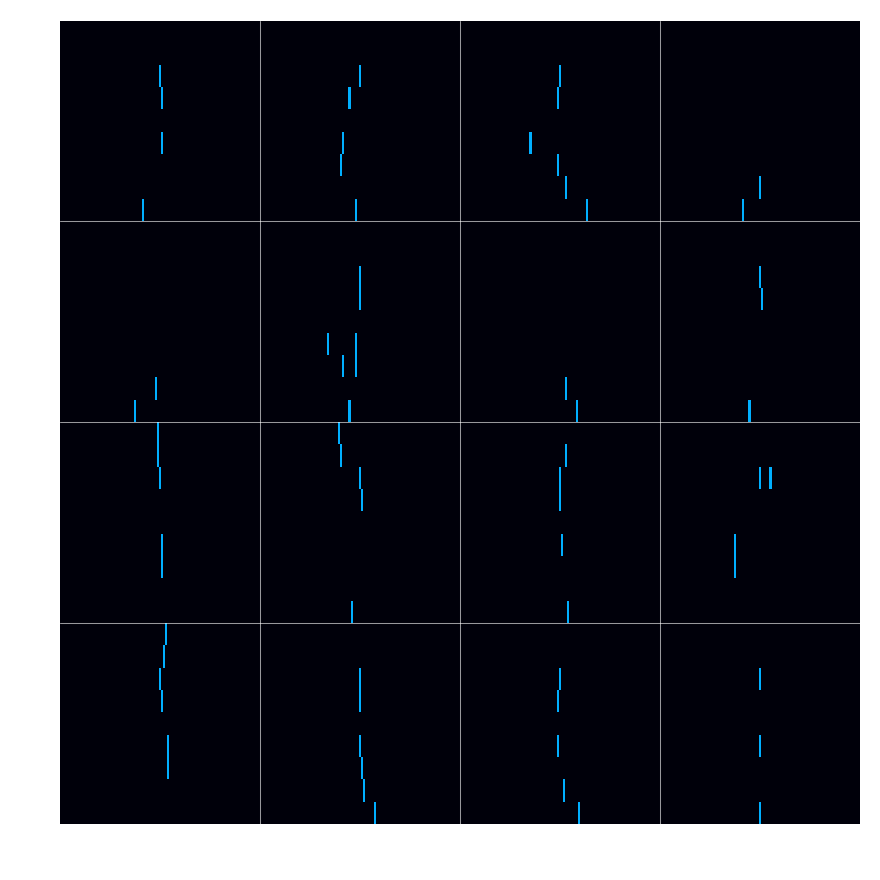

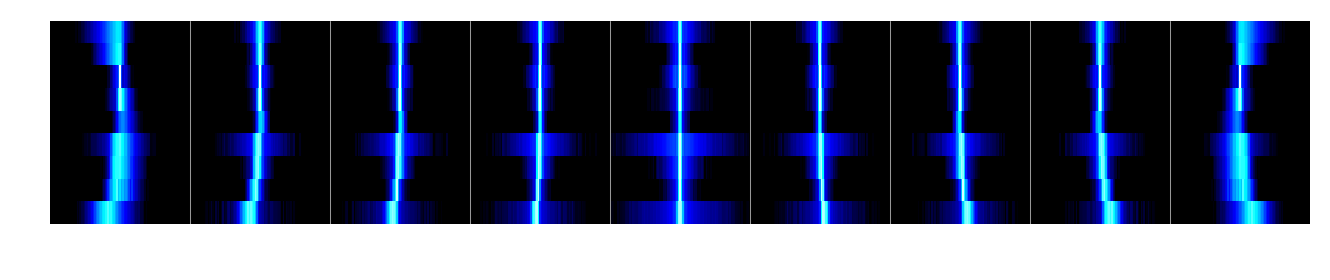

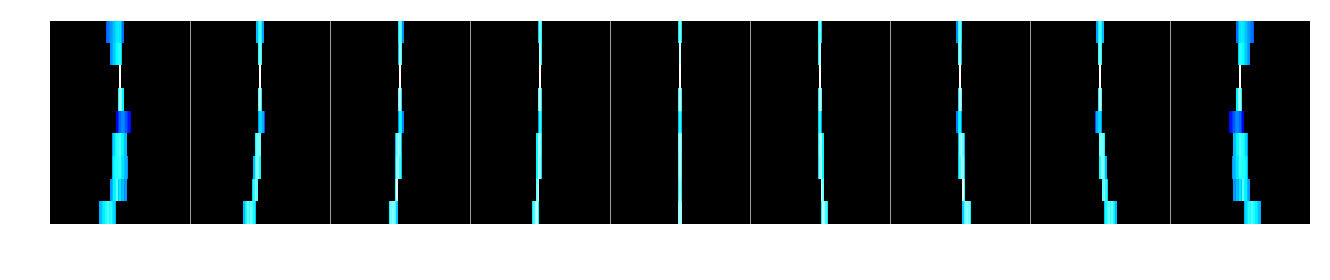

2512558 0.0 1376250.0
6 0 [35 40 42 44 46 48 50 52 54 59]
6 0 [-0.25  -0.125 -0.095 -0.06  -0.02   0.02   0.06   0.095  0.125  0.25 ]


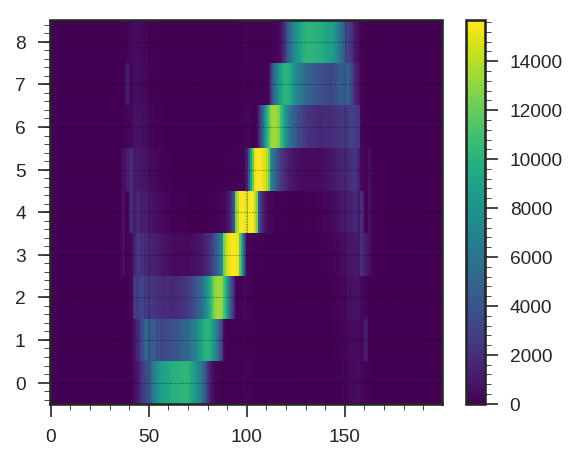

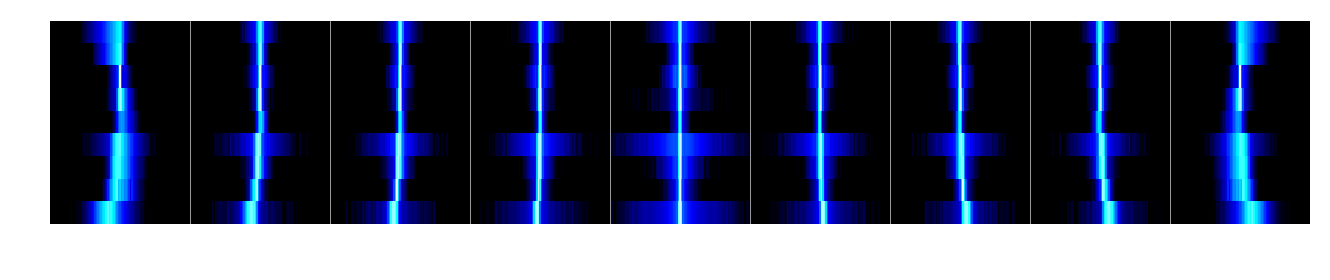

In [21]:
# All zones
for zone in xrange(nzones):
  # load dataset
  x_train, x_test, y_train, y_test = load_dataset()

  # draw images
  draw_images()
 
  draw_images2()

In [22]:
# Codes taken from
# https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py

# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
  """Reparameterization trick by sampling from an isotropic unit Gaussian.
  # Arguments
      args (tensor): mean and log of variance of Q(z|X)
  # Returns
      z (tensor): sampled latent vector
  """
  z_mean, z_log_var = args
  batch = K.shape(z_mean)[0]
  dim = K.int_shape(z_mean)[1]
  # by default, random_normal has mean = 0 and std = 1.0
  epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=1.)
  return z_mean + K.exp(0.5 * z_log_var) * epsilon

def hard_sigmoid(x):
  return K.clip((x+1.)/2.,0,1)

def relu6(x):
  return K.relu(x, alpha=0., max_value=6, threshold=0.)

In [23]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
import json

def create_model(original_dim=784, interm_dim=256, latent_dim=2, learning_rate=0.001):
  # VAE model = encoder + decoder
  # build encoder model
  input_shape = (original_dim, )
  inputs = Input(shape=input_shape, name='encoder_input')
  x = Dense(interm_dim, activation='relu')(inputs)
  z_mean = Dense(latent_dim, name='z_mean')(x)
  z_log_var = Dense(latent_dim, name='z_log_var')(x)

  # use reparameterization trick to push the sampling out as input
  # note that "output_shape" isn't necessary with the TensorFlow backend
  z = Lambda(sampling, name='z')([z_mean, z_log_var])

  # instantiate encoder model
  encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
  encoder.summary()
  display_model(encoder, show_shapes=True)

  # build decoder model
  latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
  x = Dense(interm_dim, activation='relu')(latent_inputs)
  outputs = Dense(original_dim, activation='sigmoid')(x)
  #outputs = Dense(original_dim, activation=hard_sigmoid)(x)

  # instantiate decoder model
  decoder = Model(latent_inputs, outputs, name='decoder')
  decoder.summary()
  display_model(decoder, show_shapes=True)

  # instantiate VAE model
  model_outputs = decoder(encoder(inputs)[2])
  model = Model(inputs, model_outputs, name='vae_mlp')

  # calculate VAE loss
  reconstruction_loss = K.binary_crossentropy(inputs, model_outputs)
  reconstruction_loss = K.sum(reconstruction_loss, axis=-1)
  kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  model_loss = K.mean(reconstruction_loss + kl_loss)
  model.add_loss(model_loss)

  adam = Adam(lr=learning_rate)
  model.compile(optimizer=adam, loss=None,
                metrics=[binary_crossentropy])
  model.summary()
  display_model(model, show_shapes=True)
  return encoder, decoder, model

def save_my_model(model, name='model'):
  # Store model to file
  #model.summary()
  model.save(name + '.h5')
  model.save_weights(name + '_weights.h5')
  # Store model to json
  with open(name + '.json', 'w') as outfile:
    outfile.write(model.to_json())
  return

def load_my_model(name='model.json', weights_name='model_weights.h5'):
  with open(name, 'r') as f:
    json_string = json.dumps(json.load(f))
    model = model_from_json(json_string)
  model.load_weights(weights_name)
  return model

def get_model_name():
  return model_name + ('_zone%i' % zone)

def get_model_name_enc():
  return model_name + ('_zone%i' % zone) + '_enc'

def get_model_name_dec():
  return model_name + ('_zone%i' % zone) + '_dec'

def display_model(model,
                  show_shapes=False,
                  show_layer_names=True,
                  rankdir='TB'):
  """Display a Keras model
    # Arguments
        model: A Keras model instance
        show_shapes: whether to display shape information.
        show_layer_names: whether to display layer names.
        rankdir: `rankdir` argument passed to PyDot,
            a string specifying the format of the plot:
            'TB' creates a vertical plot;
            'LR' creates a horizontal plot.
  """
  import pydot
  from keras.utils.vis_utils import model_to_dot
  dot = model_to_dot(model, show_shapes, show_layer_names, rankdir)
  
  from IPython.display import SVG, display
  display(SVG(dot.create_svg()))
  return

In [24]:
if do_training:
  # create model
  encoder, decoder, model = create_model(original_dim=original_dim, interm_dim=interm_dim, latent_dim=latent_dim,
                                         learning_rate=learning_rate)

  # train model
  history = model.fit(x_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(x_test, None))
  
  # save model
  save_my_model(model, get_model_name())
  save_my_model(encoder, get_model_name_enc())
  save_my_model(decoder, get_model_name_dec())
  
  # plot training history
  plt.figure()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

### Application

In [25]:
def plot_results(submodels,
                 data,
                 batch_size=128,
                 n_rows=28,
                 n_cols=28,
                 model_name="vae_mnist"):
  """Plots labels and MNIST digits as a function of the 2D latent vector
  # Arguments
      submodels (tuple): encoder and decoder models
      data (tuple): test data and label
      batch_size (int): prediction batch size
      model_name (string): which model is using this function
  """
  encoder, decoder = submodels
  x_test, y_test = data
  if not os.path.exists("keras_plots/" + model_name):
    os.makedirs("keras_plots/" + model_name)

  filename = os.path.join("keras_plots/" + model_name, "vae_mean.png")
  # display a 2D plot of the digit classes in the latent space
  z_mean, _, _ = encoder.predict(x_test, batch_size=1024)
  plt.figure(figsize=(10, 8))
  if latent_dim == 2:
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test[:, 0])
  elif latent_dim == 1:
    plt.scatter(z_mean[:, 0], np.random.randn(z_mean.shape[0]), c=y_test[:, 0])
  else:
    raise Exception('Unexpected latent_dim: %i' % latent_dim)
  plt.colorbar()
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.savefig(filename)
  plt.show()
  
  if latent_dim == 2:
    filename = os.path.join("keras_plots/" + model_name, "labal_vs_latent_0.png")
    plt.figure(figsize=(4, 4))
    plt.hist2d(np.arctan2(z_mean[:, 1], z_mean[:, 0]), y_test[:, 0], bins=(100,100), range=((-4,4),(-0.5,0.5)))
    plt.xlabel("z[0]")
    plt.ylabel("label")
    plt.savefig(filename)
    plt.show()
    filename = os.path.join("keras_plots/" + model_name, "labal_vs_latent_0.png")
    plt.figure(figsize=(4, 4))
    plt.hist2d(np.hypot(z_mean[:, 0], z_mean[:, 1]), y_test[:, 0], bins=(100,100), range=((-4,4),(-0.5,0.5)))
    plt.xlabel("z[1]")
    plt.ylabel("label")
    plt.savefig(filename)
    plt.show()
  elif latent_dim == 1:
    filename = os.path.join("keras_plots/" + model_name, "labal_vs_latent_0.png")
    plt.figure(figsize=(4, 4))
    plt.hist2d(z_mean[:, 0], y_test[:, 0], bins=(100,100), range=((-4,4),(-0.5,0.5)))
    plt.xlabel("z[0]")
    plt.ylabel("label")
    plt.savefig(filename)
    plt.show()
  else:
    raise Exception('Unexpected latent_dim: %i' % latent_dim)

  filename = os.path.join("keras_plots/" + model_name, "digits_over_latent.png")
  # display a 30x30 2D manifold of digits
  n = 20
  #digit_size=28,
  #figure = np.zeros((digit_size * n, digit_size * n))
  figure = np.zeros((n_rows * n, n_cols * n))
  # linearly spaced coordinates corresponding to the 2D plot
  # of digit classes in the latent space
  grid_x = np.linspace(-4, 4, n)
  grid_y = np.linspace(-4, 4, n)[::-1]

  for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
      if latent_dim == 2:
        z_sample = np.array([[xi, yi]])
      elif latent_dim == 1:
        z_sample = np.array([xi])
      else:
        raise Exception('Unexpected latent_dim: %i' % latent_dim)
      x_decoded = decoder.predict(z_sample)
      #digit = x_decoded[0].reshape(digit_size, digit_size)
      #figure[i * digit_size: (i + 1) * digit_size,
      #       j * digit_size: (j + 1) * digit_size] = digit
      digit = x_decoded[0].reshape(n_rows, n_cols)
      figure[i * n_rows: (i + 1) * n_rows,
             j * n_cols: (j + 1) * n_cols] = digit


  plt.figure(figsize=(8, 8))
  #start_range = digit_size // 2
  #end_range = n * digit_size + start_range + 1
  #pixel_range = np.arange(start_range, end_range, digit_size)
  #sample_range_x = np.round(grid_x, 1)
  #sample_range_y = np.round(grid_y, 1)
  #plt.xticks(pixel_range, sample_range_x)
  #plt.yticks(pixel_range, sample_range_y)
  plt.xticks([])
  plt.yticks([])

  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.imshow(figure, aspect='auto', 
             cmap=blue_hot, vmin=0, vmax=1.8, alpha=.9)
  plt.savefig(filename)
  plt.show()

In [26]:
def draw_generated_images():
  encoder, decoder = submodels

  n = x_train.shape[0] + x_test.shape[0]
  if latent_dim == 2:
    z_samples = np.random.randn(n, 2)
  elif latent_dim == 1:
    z_samples = np.random.randn(n)
  else:
    raise Exception('Unexpected latent_dim: %i' % latent_dim)
  x_decoded = decoder.predict(z_samples, batch_size=1024)

  from matplotlib.colors import LogNorm
  my_cmap = plt.cm.viridis
  vmin = 1e-3
  my_cmap.set_under('w',vmin)

  img = x_decoded.sum(axis=0)
  img = img.reshape((n_rows, n_cols))
  print x_decoded.shape[0], img.min(), img.max()
  img /= img.max()

  fig, ax = plt.subplots(1, 1, figsize=(4.5,4.5))
  im = ax.imshow(img, origin='lower', interpolation='nearest', aspect='auto',
                 cmap=my_cmap, vmin=vmin, norm=LogNorm(vmin=vmin, vmax=1))
  plt.colorbar(im)
  plt.show()

In [27]:
if do_training:
  # plot results
  loaded_model = load_my_model(name=get_model_name()+'.json', weights_name=get_model_name()+'_weights.h5')
  loaded_encoder = load_my_model(name=get_model_name_enc()+'.json', weights_name=get_model_name_enc()+'_weights.h5')
  loaded_decoder = load_my_model(name=get_model_name_dec()+'.json', weights_name=get_model_name_dec()+'_weights.h5')

  #submodels = (encoder, decoder)
  submodels = (loaded_encoder, loaded_decoder)
  data = (x_test, y_test)
  plot_results(submodels, data, n_rows=n_rows, n_cols=n_cols, model_name=get_model_name())

  draw_generated_images()

In [28]:
if do_training_allzones:
  
  for zone in xrange(nzones):
    print('Training model for zone%i' % zone)
    
    # load dataset
    x_train, x_test, y_train, y_test = load_dataset()

    # draw images
    draw_images()
    
    # create model
    encoder, decoder, model = create_model(original_dim=original_dim, interm_dim=interm_dim, latent_dim=latent_dim,
                                           learning_rate=learning_rate)

    # train model
    history = model.fit(x_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(x_test, None))
    
    # save model
    save_my_model(model, get_model_name())
    save_my_model(encoder, get_model_name_enc())
    save_my_model(decoder, get_model_name_dec())
    
    # plot results
    submodels = (encoder, decoder)
    draw_generated_images()

In [29]:
def edward_generator(array, batch_size):
  """Generate batch with respect to array's first axis."""
  start = 0  # pointer to where we are in iteration
  while True:
    stop = start + batch_size
    diff = stop - array.shape[0]
    if diff <= 0:
      batch = array[start:stop]
      start += batch_size
    else:
      batch = np.concatenate((array[start:], array[:diff]))
      start = diff
    #batch = batch.astype(np.float32) / 255.0  # normalize pixel intensities
    #batch = np.random.binomial(1, batch)  # binarize images
    batch = batch.astype(np.int32)
    yield batch

def edward_training():
  import edward as ed
  from edward.models import Bernoulli, Normal, Uniform
  from edward.util import Progbar

  import six
  from edward.models import RandomVariable
  from edward.util import copy, get_session
  from tensorflow.contrib.distributions import kl_divergence

  x_train_generator = edward_generator(x_train, batch_size)
  
  # MODEL
  # Define a subgraph of the full model, corresponding to a minibatch of
  # size M.
  # (a.k.a. decoder)
  z = Normal(loc=tf.zeros([batch_size, latent_dim]),
             scale=tf.ones([batch_size, latent_dim]))
  hidden = tf.layers.dense(z, interm_dim, activation=tf.nn.relu)
  x = Bernoulli(logits=tf.layers.dense(hidden, original_dim))

  # INFERENCE
  # Define a subgraph of the variational model, corresponding to a
  # minibatch of size M.
  # (a.k.a. encoder)
  x_ph = tf.placeholder(tf.int32, [batch_size, original_dim])
  hidden = tf.layers.dense(tf.cast(x_ph, tf.float32), interm_dim, activation=tf.nn.relu)
  qz = Normal(loc=tf.layers.dense(hidden, latent_dim),
              scale=tf.layers.dense(hidden, latent_dim, activation=tf.nn.softplus))
  
  # Bind p(x, z) and q(z | x) to the same TensorFlow placeholder for x.
  inference = ed.KLqp(latent_vars={z: qz}, data={x: x_ph})
  optimizer = tf.train.RMSPropOptimizer(0.01, epsilon=1.0)
  inference.initialize(optimizer=optimizer)

  tf.global_variables_initializer().run()
  
  n_iter_per_epoch = x_train.shape[0] // batch_size  # number of mini batches
  for epoch in range(1, epochs + 1):
    print("Epoch: {0}".format(epoch))
    avg_loss = 0.0

    pbar = Progbar(n_iter_per_epoch)
    for t in range(1, n_iter_per_epoch + 1):
      pbar.update(t)
      x_batch = next(x_train_generator)
      info_dict = inference.update(feed_dict={x_ph: x_batch})
      avg_loss += info_dict['loss']

    # Print a lower bound to the average marginal likelihood for an
    # image.
    avg_loss /= n_iter_per_epoch
    avg_loss /= batch_size
    print("-log p(x) <= {:0.3f}".format(avg_loss))

    if True:
      # Last batch
      p_log_lik = [0.0] * inference.n_samples
      base_scope = tf.get_default_graph().unique_name("inference") + '/'
      for s in range(inference.n_samples):
        # Form dictionary in order to replace conditioning on prior or
        # observed variable with conditioning on a specific value.
        scope = base_scope + tf.get_default_graph().unique_name("sample2")
        dict_swap = {}
        for x, qx in six.iteritems(inference.data):
          if isinstance(x, RandomVariable):
            if isinstance(qx, RandomVariable):
              qx_copy = copy(qx, scope=scope)
              dict_swap[x] = qx_copy.value()
            else:
              dict_swap[x] = qx
        #
        for z, qz in six.iteritems(inference.latent_vars):
          # Copy q(z) to obtain new set of posterior samples.
          qz_copy = copy(qz, scope=scope)
          dict_swap[z] = qz_copy.value()
        #
        for x in six.iterkeys(inference.data):
          if isinstance(x, RandomVariable):  # Bernoulli
            x_copy = copy(x, dict_swap, scope=scope)
            p_log_lik[s] += tf.reduce_sum(
                inference.scale.get(x, 1.0) * x_copy.log_prob(dict_swap[x]))
        #
      p_log_lik = tf.reduce_mean(p_log_lik)
      kl_penalty = tf.reduce_sum([
          tf.reduce_sum(inference.kl_scaling.get(z, 1.0) * kl_divergence(qz, z))
          for z, qz in six.iteritems(inference.latent_vars)])
      reg_penalty = tf.reduce_sum(tf.losses.get_regularization_losses())
      loss = -(p_log_lik - kl_penalty - reg_penalty)
      #
      sess = get_session()
      feed_dict = {x_ph: x_batch}
      p_log_lik, kl_penalty, reg_penalty, loss = sess.run([p_log_lik, kl_penalty, reg_penalty, loss], feed_dict)
      #
      print "p_log_lik", p_log_lik / batch_size
      print "kl_penalty", kl_penalty / batch_size
      print "reg_penalty", reg_penalty / batch_size
      print "loss", loss / batch_size

    # Prior predictive check.
    #images = x.eval()
    #for m in range(batch_size):
    #  imsave(os.path.join("keras_plots/" + model_name, '%d.png') % m,
    #         images[m].reshape(n_rows, n_cols))

  return x_ph, qz, x

In [30]:
if do_training_edward:
  x_ph, qz, bern = edward_training()

In [31]:
if do_training_edward:
  images = bern.eval()
  for m in range(10):
    fig, ax = plt.subplots(1, 1, figsize=(2,2))
    ax.imshow(images[m].reshape(n_rows, n_cols), aspect='auto')
  plt.show()

In [32]:
if do_training_edward:
  n_iter_per_epoch = x_test.shape[0] // batch_size  # number of mini batches
  y_true = []
  y_pred = []
  for t in range(1, n_iter_per_epoch + 1):
    x_batch = x_test[batch_size*(t-1):batch_size*t]
    y_batch = y_test[batch_size*(t-1):batch_size*t]
    feed_dict={x_ph: x_batch}
    qz_eval = qz.eval(feed_dict=feed_dict)
    y_true.append(y_batch)
    y_pred.append(qz_eval)

  y_true = np.concatenate(y_true)
  y_pred = np.concatenate(y_pred)
  print x_test.shape[0], y_true.shape, y_pred.shape
  
  plt.figure(figsize=(10, 8))
  if latent_dim == 2:
    plt.scatter(y_pred[:, 0], y_pred[:, 1], c=y_true)
  elif latent_dim == 1:
    plt.scatter(y_pred[:, 0], np.random.randn(y_pred.shape[0]), c=y_true)
  else:
    raise Exception('Unexpected latent_dim: %i' % latent_dim)
  plt.colorbar()
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  #plt.savefig(filename)
  plt.show()

In [33]:
### IGNORE THE FOLLOWING